# **MedVQA (VQA-RAD)**
## **Alternative Assessment WOA7015**

OCC 3


---


Chang Kai Xin (23109141)

Yoong Jia Yin (24065194)

In [ ]:
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights

from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score,
    confusion_matrix, classification_report,
    precision_score, recall_score)

In [ ]:
# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/VQA-RAD'
IMAGE_DIR = '/content/drive/MyDrive/VQA-RAD/VQA_RAD_Image'
SAVE_DIR = '/content/drive/MyDrive/VQA-RAD/woa7015outputs'
MODEL_DIR = '/content/drive/MyDrive/VQA-RAD/woa7015models'

Mounted at /content/drive


In [ ]:
#Data cleaning
def clean_data(data):
  cleaned_count = 0

  for item in data:
    original_type = item.get('answer_type','')
    item['answer_type'] = item['answer_type'].strip().upper()
    item['answer'] = str(item['answer']).lower().strip()
    item['question'] = item['question'].strip()

    if original_type != item['answer_type']:
      cleaned_count += 1
      print(f"Fixed: '{original_type}' -> '{item['answer_type']}'")

  return data, cleaned_count


json_path = f'{DATA_DIR}/VQA_RAD.json'

with open(json_path, 'r') as f:
    all_data = json.load(f)

print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)
all_data, cleaned = clean_data(all_data)
if cleaned > 0:
  print(f"Cleaned {cleaned} samples with formatting issues")
else:
  print("Data is clean")
print("="*60 + "\n")


DATA CLEANING
Fixed: 'CLOSED ' -> 'CLOSED'
Fixed: 'CLOSED ' -> 'CLOSED'
Cleaned 2 samples with formatting issues



# Exploratory Data Analysis

In [ ]:
print(f"{'='*60}")
print("VQA-RAD Dataset Statistics")
print(f"{'='*60}")
print(f"Total samples: {len(all_data)}")

#Answer type distribution
answer_types = Counter([item['answer_type'] for item in all_data])
print(f"\nAnswer Type Distribution:")
for ans_type, count in answer_types.items():
    print(f"  {ans_type}: {count} ({100*count/len(all_data):.1f}%)")

# Count unique answers
unique_answers = set([str(item['answer']).lower() for item in all_data])
print(f"\nUnique answers: {len(unique_answers)}")

# Most common answers
all_answers = [str(item['answer']).lower() for item in all_data]
answer_counts = Counter(all_answers)
print(f"\nTop 10 Most Common Answers:")
for ans, count in answer_counts.most_common(10):
    print(f"  '{ans}': {count}")

# Question types
question_types = Counter([item['question_type'] for item in all_data])
print(f"\nTop 10 Question Types:")
for q_type, count in question_types.most_common(10):
    print(f"  {q_type}: {count}")

VQA-RAD Dataset Statistics
Total samples: 2248

Answer Type Distribution:
  CLOSED: 1299 (57.8%)
  OPEN: 949 (42.2%)

Unique answers: 517

Top 10 Most Common Answers:
  'no': 606
  'yes': 587
  'axial': 43
  'right': 26
  'left': 19
  'pa': 15
  'ct': 13
  'brain': 13
  'fat': 9
  'one': 8

Top 10 Question Types:
  PRES: 800
  POS: 316
  ABN: 202
  OTHER: 194
  MODALITY: 185
  SIZE: 171
  PLANE: 120
  ATTRIB: 87
  ORGAN: 59
  COLOR: 52


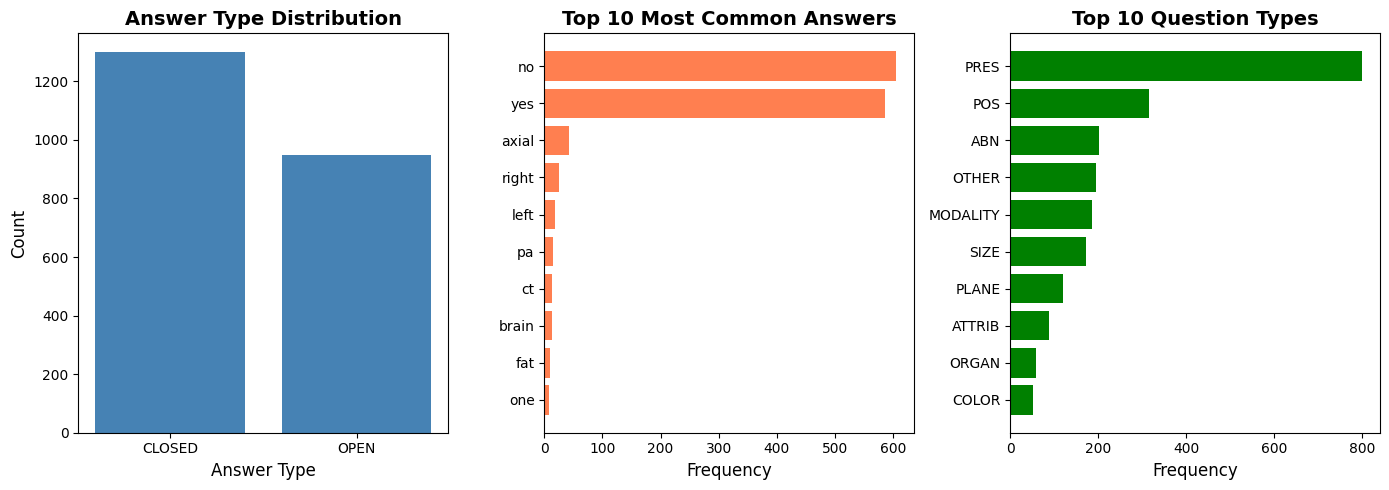

In [ ]:
# Visualize data distribution
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Answer types
ax = axes[0]
types = list(answer_types.keys())
counts = list(answer_types.values())
ax.bar(types, counts, color='steelblue')
ax.set_title('Answer Type Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Answer Type', fontsize=12)

# Top answers
ax = axes[1]
top_answers = answer_counts.most_common(10)
answers, counts = zip(*top_answers)
ax.barh(range(len(answers)), counts, color='coral')
ax.set_yticks(range(len(answers)))
ax.set_yticklabels(answers)
ax.set_title('Top 10 Most Common Answers', fontsize=14, fontweight='bold')
ax.set_xlabel('Frequency', fontsize=12)
ax.invert_yaxis()

# Top question types
ax = axes[2]
top_types = question_types.most_common(10)
types, counts = zip(*top_types)
ax.barh(range(len(types)), counts, color='green')
ax.set_yticks(range(len(types)))
ax.set_yticklabels(types)
ax.set_title('Top 10 Question Types', fontsize=14, fontweight='bold')
ax.set_xlabel('Frequency', fontsize=12)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

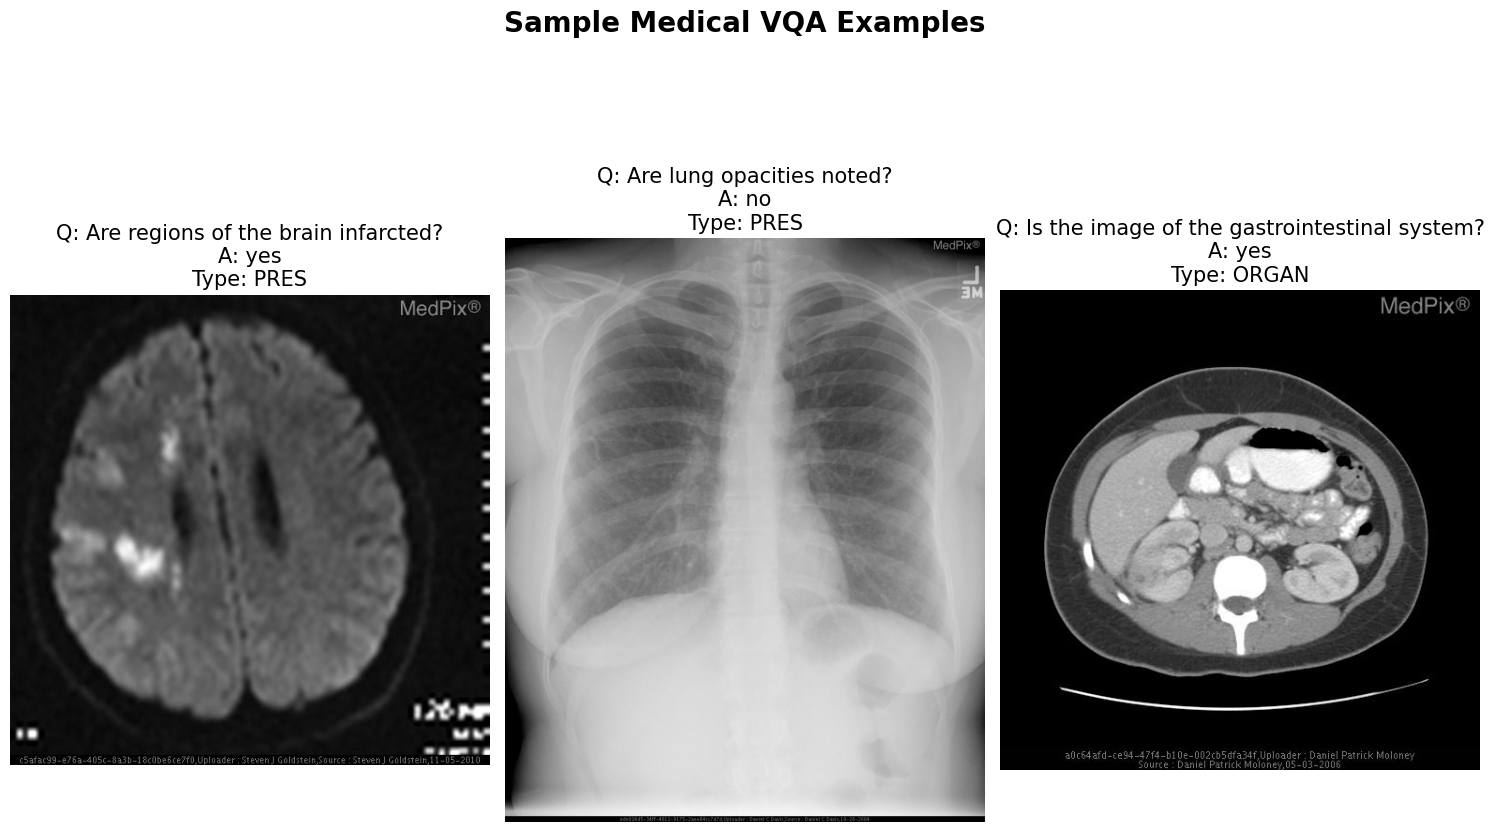

In [ ]:
# Display sample images with questions
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(3):
    sample = all_data[i * 100]  # Sample every 100th item

    # Load image
    img_name = sample['image_name']
    img_path = f"{IMAGE_DIR}/{img_name}"

    try:
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')

        # Add question and answer as title
        question = sample['question'][:60] + '...' if len(sample['question']) > 60 else sample['question']
        answer = sample['answer']
        axes[i].set_title(
            f"Q: {question}\nA: {answer}\nType: {sample['question_type']}",
            fontsize=15
        )
    except Exception as e:
        axes[i].text(0.5, 0.5, f'Image not found\n{img_name}',
                    ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Sample Medical VQA Examples', fontsize=20, fontweight='bold', y=1.02)
plt.show()

# Data Splitting

In [ ]:
#Split into 80:20
train_data, test_data = train_test_split(
    all_data,
    test_size=0.2,
    random_state=42
)

#Save splits
train_path = f'{SAVE_DIR}/train_data.json'
test_path = f'{SAVE_DIR}/test_data.json'

with open(train_path, 'w') as f:
    json.dump(train_data, f)

with open(test_path, 'w') as f:
    json.dump(test_data, f)

print(f"Saved {len(train_data)} train samples to {train_path}")
print(f"Saved {len(test_data)} test samples to {test_path}\n")

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

train_csv_path = f'{SAVE_DIR}/train_data.csv'
test_csv_path = f'{SAVE_DIR}/test_data.csv'

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)
print(f"Saved train CSV to {train_csv_path}")
print(f"Saved test CSV to {test_csv_path}")

Saved 1798 train samples to /content/drive/MyDrive/VQA-RAD/woa7015outputs/train_data.json
Saved 450 test samples to /content/drive/MyDrive/VQA-RAD/woa7015outputs/test_data.json

Saved train CSV to /content/drive/MyDrive/VQA-RAD/woa7015outputs/train_data.csv
Saved test CSV to /content/drive/MyDrive/VQA-RAD/woa7015outputs/test_data.csv


# Baseline Dataset Definition

In [ ]:
class VQARADDataset(Dataset):

    def __init__(self, data_path, image_dir, answer_vocab=None,
                 question_vocab=None, max_length=50, transform=None):

        with open(data_path, 'r') as f:
            self.data = json.load(f)

        self.image_dir = image_dir
        self.max_length = max_length

        # Build vocabularies
        if question_vocab is None:
            self.question_vocab = self._build_question_vocab()
        else:
            self.question_vocab = question_vocab

        if answer_vocab is None:
            self.answer_vocab = self._build_answer_vocab()
        else:
            self.answer_vocab = answer_vocab

        # Image transforms
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ])
        else:
            self.transform = transform

    # Build vocabulary from questions
    def _build_question_vocab(self):
        vocab = {'<PAD>': 0, '<UNK>': 1}

        for item in self.data:
            question = item['question'].lower()
            for word in question.split():
                if word not in vocab:
                    vocab[word] = len(vocab)

        return vocab

    # Build vocabulary for answers
    def _build_answer_vocab(self):
        vocab = {}

        for item in self.data:
            answer = str(item['answer']).lower().strip()
            if answer not in vocab:
                vocab[answer] = len(vocab)

        return vocab

    # Convert question to token indices
    def tokenize_question(self, question):
        tokens = question.lower().split()[:self.max_length]
        indices = [
            self.question_vocab.get(word, self.question_vocab['<UNK>'])
            for word in tokens
        ]
        padding = [self.question_vocab['<PAD>']] * (self.max_length - len(indices))
        indices += padding
        return torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = f"{self.image_dir}/{item['image_name']}"

        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
        except:
            # Fallback to black image if loading fails
            image = torch.zeros(3, 224, 224)

        question = self.tokenize_question(item['question']) # Tokenize question

        # Get answer index
        answer_text = str(item['answer']).lower().strip()
        answer = self.answer_vocab.get(answer_text, -1)

        return {
            'image': image,
            'question': question,
            'answer': answer,
            'question_text': item['question'],
            'answer_text': answer_text,
            'question_type': item.get('question_type', 'unknown'),
            'answer_type': item.get('answer_type', 'UNKNOWN')
        }

print("Dataset class defined")

Dataset class defined


In [ ]:
# Create datasets
print("Creating datasets...\n")

train_dataset = VQARADDataset(
    data_path=train_path,
    image_dir=IMAGE_DIR
)

#Extract vocab
question_vocab = train_dataset.question_vocab
answer_vocab = train_dataset.answer_vocab

#Save vocabularies
os.makedirs(SAVE_DIR, exist_ok=True)
with open(f'{SAVE_DIR}/question_vocab.json', 'w') as f:
  json.dump(question_vocab, f, indent=2)
with open(f'{SAVE_DIR}/answer_vocab.json', 'w') as f:
  json.dump(answer_vocab, f, indent=2)

#create and save reverse mappings
answer_idx_to_word = {idx: ans for ans, idx in answer_vocab.items()}
with open(f'{SAVE_DIR}/answer_idx_to_word.json','w') as f:
  json.dump({str(k): v for k, v in answer_idx_to_word.items()}, f, indent=2)

print(f"Saved vocabularies to {SAVE_DIR}/")

# Create test dataset using train vocab
test_dataset = VQARADDataset(
    data_path=test_path,
    image_dir=IMAGE_DIR,
    answer_vocab=answer_vocab,
    question_vocab=question_vocab
)

BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"  Training samples: {len(train_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print(f"  Question vocab size: {len(train_dataset.question_vocab)}")
print(f"  Answer vocab size: {len(train_dataset.answer_vocab)}")

Creating datasets...

Saved vocabularies to /content/drive/MyDrive/VQA-RAD/woa7015outputs/
  Training samples: 1798
  Test samples: 450
  Question vocab size: 1417
  Answer vocab size: 458


# CNN-LSTM Model Definition

In [ ]:
class AttentionFusion(nn.Module):
  def __init__(self, image_dim, text_dim, fusion_dim=512, dropout=0.2):
    super().__init__()
    self.image_proj = nn.Linear(image_dim, fusion_dim)
    self.text_proj = nn.Linear(text_dim, fusion_dim)
    self.attn = nn.Linear(fusion_dim, 1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, image_features, question_features):
    image_proj = torch.tanh(self.image_proj(image_features))
    text_proj = torch.tanh(self.text_proj(question_features))

    attn_inputs = torch.stack([image_proj, text_proj], dim=1)
    attn_scores = self.attn(attn_inputs).squeeze(-1)
    attn_weights = torch.softmax(attn_scores, dim=1).unsqueeze(-1)

    fused = (attn_inputs * attn_weights).sum(dim=1)
    return self.dropout(fused)


class CNNLSTM(nn.Module):

    def __init__(self, vocab_size, num_classes, embedding_dim=512,
                 hidden_dim=1024, dropout=0.5):
        super().__init__()

        # Image Encoder (ResNet50)
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.image_dim = 2048

        # Question Encoder (LSTM)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = (
            nn.LSTM(
            embedding_dim,
            hidden_dim,
            batch_first=True,
        )
)

        self.fusion = AttentionFusion(self.image_dim, hidden_dim, fusion_dim=512, dropout=0.2)
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, image, question):
      image_features = self.image_encoder(image).squeeze(-1).squeeze(-1)
      embedded = self.embedding(question)
      _, (hidden, _) = self.lstm(embedded)
      question_features = hidden[-1]

      fused = self.fusion(image_features, question_features)
      logits = self.classifier(fused)
      return logits

    def freeze_resnet(self):
      for param in self.image_encoder.parameters():
          param.requires_grad = False

    #Unfreeze last 2 ResNet blocks for fine-tuning
    def unfreeze_resnet(self):
      for param in self.image_encoder.parameters():
          param.requires_grad = True

print("CNN-LSTM model class defined")

CNN-LSTM model class defined


# CNN-LSTM Training Functions

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc='Training')
    for batch in progress_bar:
        images = batch['image'].to(device)
        questions = batch['question'].to(device)
        answers = batch['answer'].to(device)

        mask = answers != -1 # Filter out invalid answers
        if mask.sum() == 0:
            continue

        images = images[mask]
        questions = questions[mask]
        answers = answers[mask]

        # Forward
        optimizer.zero_grad()
        outputs = model(images, questions)
        loss = criterion(outputs, answers)

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += answers.size(0)
        correct += (predicted == answers).sum().item()

        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })

    return total_loss / total, 100 * correct / total


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_targets = []

    for batch in tqdm(loader, desc='Validation'):
        images = batch['image'].to(device)
        questions = batch['question'].to(device)
        answers = batch['answer'].to(device)

        mask = answers != -1
        if mask.sum() == 0:
            continue

        images = images[mask]
        questions = questions[mask]
        answers = answers[mask]

        outputs = model(images, questions)
        loss = criterion(outputs, answers)

        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += answers.size(0)
        correct += (predicted == answers).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(answers.cpu().numpy())

    acc = 100 * correct / total
    f1 = f1_score(all_targets, all_preds, average='weighted')
    return total_loss / total, acc, f1

print("Training functions defined")

Training functions defined


# CNN-LSTM Training

In [ ]:
def run_cnn_lstm(strategy, freeze_unfreeze=True, phase1_epochs=15, phase2_epochs=15, total_epochs=30):
  vocab_size = len(question_vocab)
  num_classes = len(answer_vocab)

  model = CNNLSTM(
      vocab_size=vocab_size,
      num_classes=num_classes,
      embedding_dim=512,
      hidden_dim=1024,
      dropout=0.5
  ).to(device)

  if freeze_unfreeze:
    model.freeze_resnet()
  else:
    model.unfreeze_resnet()

  criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
  optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)

  history = {
      'train_loss': [],
      'train_acc': [],
      'val_loss': [],
      'val_acc': [],
      'val_f1': []
  }

  best_val_acc = 0.0
  best_ckpt_path = f'{MODEL_DIR}/cnn_lstm_{strategy}_best.pt'

  if freeze_unfreeze:
    print("\n" + "="*60)
    print(f"CNN-LSTM: {strategy} PHASE 1: Frozen ResNet")
    print("="*60 + "\n")

    for epoch in range(1, phase1_epochs + 1):
      print(f"\nEpoch {epoch}/{total_epochs}")
      print("-" * 60)

      train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
      val_loss, val_acc, val_f1 = validate(model, test_loader, criterion, device)

      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['val_f1'].append(val_f1)

      print(f"\nResults:")
      print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
      print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

      # Save best model
      if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'best_val_acc': best_val_acc,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss
        }
        torch.save(checkpoint, best_ckpt_path)
        print(f"  Best model saved! (Val Acc: {val_acc:.2f}%)")


    print("\n" + "="*60)
    print("PHASE 2: Unfreeze ResNet")
    print("="*60 + "\n")

    model.unfreeze_resnet()
    for param_group in optimizer.param_groups:
      param_group['lr'] = 1e-5
    for epoch in range(1, phase2_epochs + 1):
      print(f"\nEpoch {phase1_epochs + epoch}/{phase1_epochs + phase2_epochs}")
      print("-" * 60)

      train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
      val_loss, val_acc, val_f1 = validate(model, test_loader, criterion, device)

      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['val_f1'].append(val_f1)

      print(f"\nResults:")
      print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
      print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

      if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'best_val_acc': best_val_acc,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss
        }
        torch.save(checkpoint, best_ckpt_path)
        print(f"  Best model saved! (Val Acc: {val_acc:.2f}%)")
    print(f"\n{strategy} Complete! Best Val Acc: {best_val_acc:.2f}%")

  else: #end2end
    print("\n" + "="*60)
    print(f"CNN-LSTM: {strategy}")
    print("="*60 + "\n")

    for epoch in range(1, total_epochs + 1):
      print(f"\nEpoch {epoch}/{total_epochs}")
      print("-" * 60)
      train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
      val_loss, val_acc, val_f1 = validate(model, test_loader, criterion, device)

      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['val_f1'].append(val_f1)

      print(f"\nResults:")
      print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
      print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

      if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'best_val_acc': best_val_acc,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss
        }
        torch.save(checkpoint, best_ckpt_path)
        print(f"  Best model saved! (Val Acc: {val_acc:.2f}%)")
    print(f"\n{strategy} Complete! Best Val Acc: {best_val_acc:.2f}%")
  return model, history, best_ckpt_path

In [ ]:
cnn_lstm_freeze_model, cnn_lstm_freeze_history, cnn_lstm_freeze_ckpt = run_cnn_lstm(
    strategy='freeze_unfreeze',
    freeze_unfreeze=True,
    phase1_epochs=15,
    phase2_epochs=15
)

cnn_lstm_e2e_model, cnn_lstm_e2e_history, cnn_lstm_e2e_ckpt = run_cnn_lstm(
    strategy='end_to_end',
    freeze_unfreeze=False,
    total_epochs=30
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]



CNN-LSTM: freeze_unfreeze PHASE 1: Frozen ResNet


Epoch 1/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]



Results:
  Train Loss: 4.9744 | Train Acc: 26.42%
  Val Loss: 3.9490 | Val Acc: 34.81% | Val F1: 0.2601
  Best model saved! (Val Acc: 34.81%)

Epoch 2/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]



Results:
  Train Loss: 4.2470 | Train Acc: 31.31%
  Val Loss: 3.9401 | Val Acc: 34.55% | Val F1: 0.2584

Epoch 3/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]



Results:
  Train Loss: 4.1444 | Train Acc: 31.65%
  Val Loss: 3.7317 | Val Acc: 35.06% | Val F1: 0.2623
  Best model saved! (Val Acc: 35.06%)

Epoch 4/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]



Results:
  Train Loss: 4.0856 | Train Acc: 32.42%
  Val Loss: 3.7428 | Val Acc: 37.14% | Val F1: 0.2701
  Best model saved! (Val Acc: 37.14%)

Epoch 5/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]



Results:
  Train Loss: 4.0170 | Train Acc: 34.26%
  Val Loss: 3.7144 | Val Acc: 38.44% | Val F1: 0.2874
  Best model saved! (Val Acc: 38.44%)

Epoch 6/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]



Results:
  Train Loss: 3.9549 | Train Acc: 36.10%
  Val Loss: 3.7191 | Val Acc: 37.40% | Val F1: 0.2781

Epoch 7/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]



Results:
  Train Loss: 3.9045 | Train Acc: 37.71%
  Val Loss: 3.6707 | Val Acc: 38.44% | Val F1: 0.2861

Epoch 8/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]



Results:
  Train Loss: 3.8391 | Train Acc: 38.54%
  Val Loss: 3.6041 | Val Acc: 38.96% | Val F1: 0.2897
  Best model saved! (Val Acc: 38.96%)

Epoch 9/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]



Results:
  Train Loss: 3.8041 | Train Acc: 38.15%
  Val Loss: 3.5826 | Val Acc: 39.74% | Val F1: 0.2986
  Best model saved! (Val Acc: 39.74%)

Epoch 10/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]



Results:
  Train Loss: 3.7435 | Train Acc: 39.60%
  Val Loss: 3.6629 | Val Acc: 37.66% | Val F1: 0.2797

Epoch 11/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]



Results:
  Train Loss: 3.6659 | Train Acc: 40.38%
  Val Loss: 3.5732 | Val Acc: 39.74% | Val F1: 0.2979

Epoch 12/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]



Results:
  Train Loss: 3.6268 | Train Acc: 40.49%
  Val Loss: 3.5291 | Val Acc: 39.48% | Val F1: 0.2953

Epoch 13/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]



Results:
  Train Loss: 3.5420 | Train Acc: 40.93%
  Val Loss: 3.4609 | Val Acc: 40.52% | Val F1: 0.3030
  Best model saved! (Val Acc: 40.52%)

Epoch 14/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]



Results:
  Train Loss: 3.4846 | Train Acc: 40.88%
  Val Loss: 3.4300 | Val Acc: 42.86% | Val F1: 0.3217
  Best model saved! (Val Acc: 42.86%)

Epoch 15/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]



Results:
  Train Loss: 3.4285 | Train Acc: 41.16%
  Val Loss: 3.4100 | Val Acc: 42.34% | Val F1: 0.3171

PHASE 2: Unfreeze ResNet


Epoch 16/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]



Results:
  Train Loss: 3.3454 | Train Acc: 41.21%
  Val Loss: 3.4082 | Val Acc: 41.30% | Val F1: 0.3117

Epoch 17/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]



Results:
  Train Loss: 3.3150 | Train Acc: 41.94%
  Val Loss: 3.3979 | Val Acc: 42.60% | Val F1: 0.3216

Epoch 18/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]



Results:
  Train Loss: 3.2996 | Train Acc: 42.27%
  Val Loss: 3.4021 | Val Acc: 42.60% | Val F1: 0.3214

Epoch 19/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]



Results:
  Train Loss: 3.2942 | Train Acc: 42.66%
  Val Loss: 3.3915 | Val Acc: 41.30% | Val F1: 0.3130

Epoch 20/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]



Results:
  Train Loss: 3.2591 | Train Acc: 42.88%
  Val Loss: 3.4005 | Val Acc: 42.08% | Val F1: 0.3195

Epoch 21/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]



Results:
  Train Loss: 3.2428 | Train Acc: 42.83%
  Val Loss: 3.4015 | Val Acc: 41.04% | Val F1: 0.3118

Epoch 22/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]



Results:
  Train Loss: 3.2487 | Train Acc: 41.94%
  Val Loss: 3.3944 | Val Acc: 41.56% | Val F1: 0.3153

Epoch 23/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s]



Results:
  Train Loss: 3.2476 | Train Acc: 42.21%
  Val Loss: 3.3883 | Val Acc: 41.56% | Val F1: 0.3157

Epoch 24/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]



Results:
  Train Loss: 3.2379 | Train Acc: 42.94%
  Val Loss: 3.3837 | Val Acc: 41.30% | Val F1: 0.3141

Epoch 25/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]



Results:
  Train Loss: 3.2419 | Train Acc: 42.10%
  Val Loss: 3.3880 | Val Acc: 41.82% | Val F1: 0.3181

Epoch 26/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]



Results:
  Train Loss: 3.2256 | Train Acc: 42.77%
  Val Loss: 3.3778 | Val Acc: 41.30% | Val F1: 0.3142

Epoch 27/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]



Results:
  Train Loss: 3.2241 | Train Acc: 42.77%
  Val Loss: 3.3886 | Val Acc: 40.26% | Val F1: 0.3062

Epoch 28/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]



Results:
  Train Loss: 3.2037 | Train Acc: 43.16%
  Val Loss: 3.3711 | Val Acc: 42.08% | Val F1: 0.3197

Epoch 29/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]



Results:
  Train Loss: 3.2073 | Train Acc: 42.94%
  Val Loss: 3.3680 | Val Acc: 41.56% | Val F1: 0.3161

Epoch 30/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]



Results:
  Train Loss: 3.1908 | Train Acc: 43.27%
  Val Loss: 3.3689 | Val Acc: 41.56% | Val F1: 0.3189

freeze_unfreeze Complete! Best Val Acc: 42.86%

CNN-LSTM: end_to_end


Epoch 1/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]



Results:
  Train Loss: 4.8089 | Train Acc: 26.59%
  Val Loss: 3.8889 | Val Acc: 32.99% | Val F1: 0.2414
  Best model saved! (Val Acc: 32.99%)

Epoch 2/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]



Results:
  Train Loss: 4.1419 | Train Acc: 30.14%
  Val Loss: 3.8229 | Val Acc: 36.36% | Val F1: 0.2718
  Best model saved! (Val Acc: 36.36%)

Epoch 3/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]



Results:
  Train Loss: 4.0293 | Train Acc: 33.37%
  Val Loss: 3.7246 | Val Acc: 38.96% | Val F1: 0.2857
  Best model saved! (Val Acc: 38.96%)

Epoch 4/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]



Results:
  Train Loss: 3.9483 | Train Acc: 37.21%
  Val Loss: 3.6967 | Val Acc: 42.08% | Val F1: 0.3152
  Best model saved! (Val Acc: 42.08%)

Epoch 5/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]



Results:
  Train Loss: 3.8580 | Train Acc: 38.38%
  Val Loss: 3.6234 | Val Acc: 40.52% | Val F1: 0.2987

Epoch 6/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]



Results:
  Train Loss: 3.7561 | Train Acc: 40.32%
  Val Loss: 3.5058 | Val Acc: 43.64% | Val F1: 0.3283
  Best model saved! (Val Acc: 43.64%)

Epoch 7/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]



Results:
  Train Loss: 3.6475 | Train Acc: 40.04%
  Val Loss: 3.4574 | Val Acc: 42.34% | Val F1: 0.3189

Epoch 8/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.90it/s]



Results:
  Train Loss: 3.5082 | Train Acc: 41.71%
  Val Loss: 3.4443 | Val Acc: 41.82% | Val F1: 0.3167

Epoch 9/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]



Results:
  Train Loss: 3.3767 | Train Acc: 40.88%
  Val Loss: 3.3676 | Val Acc: 41.82% | Val F1: 0.3218

Epoch 10/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]



Results:
  Train Loss: 3.2396 | Train Acc: 42.44%
  Val Loss: 3.2935 | Val Acc: 42.34% | Val F1: 0.3317

Epoch 11/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]



Results:
  Train Loss: 3.1168 | Train Acc: 41.88%
  Val Loss: 3.2732 | Val Acc: 42.08% | Val F1: 0.3385

Epoch 12/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]



Results:
  Train Loss: 2.9891 | Train Acc: 42.21%
  Val Loss: 3.2221 | Val Acc: 41.56% | Val F1: 0.3341

Epoch 13/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]



Results:
  Train Loss: 2.8790 | Train Acc: 44.27%
  Val Loss: 3.1983 | Val Acc: 40.26% | Val F1: 0.3329

Epoch 14/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]



Results:
  Train Loss: 2.7616 | Train Acc: 43.77%
  Val Loss: 3.1608 | Val Acc: 41.30% | Val F1: 0.3452

Epoch 15/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]



Results:
  Train Loss: 2.6963 | Train Acc: 43.94%
  Val Loss: 3.1146 | Val Acc: 39.74% | Val F1: 0.3448

Epoch 16/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]



Results:
  Train Loss: 2.6181 | Train Acc: 43.88%
  Val Loss: 3.0958 | Val Acc: 38.96% | Val F1: 0.3374

Epoch 17/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]



Results:
  Train Loss: 2.5505 | Train Acc: 43.27%
  Val Loss: 3.0919 | Val Acc: 38.96% | Val F1: 0.3480

Epoch 18/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]



Results:
  Train Loss: 2.4936 | Train Acc: 43.55%
  Val Loss: 3.0786 | Val Acc: 38.18% | Val F1: 0.3408

Epoch 19/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]



Results:
  Train Loss: 2.4465 | Train Acc: 44.66%
  Val Loss: 3.0401 | Val Acc: 38.18% | Val F1: 0.3452

Epoch 20/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]



Results:
  Train Loss: 2.4037 | Train Acc: 45.11%
  Val Loss: 3.0263 | Val Acc: 37.92% | Val F1: 0.3424

Epoch 21/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]



Results:
  Train Loss: 2.3881 | Train Acc: 43.77%
  Val Loss: 3.0330 | Val Acc: 36.10% | Val F1: 0.3346

Epoch 22/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]



Results:
  Train Loss: 2.3528 | Train Acc: 42.99%
  Val Loss: 3.0361 | Val Acc: 38.44% | Val F1: 0.3493

Epoch 23/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]



Results:
  Train Loss: 2.3352 | Train Acc: 43.77%
  Val Loss: 3.0117 | Val Acc: 36.88% | Val F1: 0.3418

Epoch 24/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]



Results:
  Train Loss: 2.3210 | Train Acc: 43.99%
  Val Loss: 3.0267 | Val Acc: 36.88% | Val F1: 0.3461

Epoch 25/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]



Results:
  Train Loss: 2.2936 | Train Acc: 44.55%
  Val Loss: 3.0263 | Val Acc: 35.84% | Val F1: 0.3382

Epoch 26/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]



Results:
  Train Loss: 2.2901 | Train Acc: 43.99%
  Val Loss: 3.0180 | Val Acc: 35.58% | Val F1: 0.3308

Epoch 27/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]



Results:
  Train Loss: 2.2696 | Train Acc: 44.66%
  Val Loss: 3.0441 | Val Acc: 35.58% | Val F1: 0.3412

Epoch 28/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]



Results:
  Train Loss: 2.2682 | Train Acc: 42.94%
  Val Loss: 3.0466 | Val Acc: 35.58% | Val F1: 0.3352

Epoch 29/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]



Results:
  Train Loss: 2.2321 | Train Acc: 43.94%
  Val Loss: 3.0556 | Val Acc: 36.88% | Val F1: 0.3454

Epoch 30/30
------------------------------------------------------------


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


Results:
  Train Loss: 2.2421 | Train Acc: 43.33%
  Val Loss: 3.0591 | Val Acc: 37.66% | Val F1: 0.3472

end_to_end Complete! Best Val Acc: 43.64%


# Evaluation Functions

In [ ]:
def detailed_evaluation(model, dataloader, answer_vocab, answer_idx_to_word,
                       question_data, device, save_dir):

    model.eval()

    all_predictions = []
    all_targets = []
    all_logits = []

    print("Running inference on test set...")
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
          if 'image' in batch:
            images = batch['image'].to(device)
            questions = batch['question'].to(device)
            answers = batch['answer'].to(device)
            logits = model(images, questions)
          else:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            answers = batch['label'].to(device)
            logits = model(pixel_values, input_ids, attention_mask)

          _, predicted = torch.max(logits, dim=1)

          all_predictions.extend(predicted.cpu().numpy())
          all_targets.extend(answers.cpu().numpy())
          all_logits.append(logits.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_logits = np.concatenate(all_logits, axis=0)

    print(f"Total samples: {len(all_targets)}")

    invalid_mask = (all_targets == -1) #Check for -1 values
    num_invalid = invalid_mask.sum()

    if num_invalid > 0:
      print(f"Found {num_invalid} samples with missing answer (answer = -1)")
      print(f"These will be excluded from evaluation")
      valid_mask = ~invalid_mask #Filter out invalid samples
      all_predictions = all_predictions[valid_mask]
      all_targets = all_targets[valid_mask]
      all_logits = all_logits[valid_mask]
      print(f"\nEvaluating on {len(all_targets)} valid samples")

    else:
      print(f"All samples are valid.")

    overall_acc = accuracy_score(all_targets, all_predictions)
    overall_f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)

    print(f"\n{'='*60}")
    print("OVERALL PERFORMANCE")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {overall_acc*100:.2f}%")
    print(f"Overall F1-Score: {overall_f1:.4f}")

    results = {
        'overall': {
            'accuracy': overall_acc,
            'f1_score': overall_f1,
            'total_samples': len(all_targets),
            'excluded_samples': int(num_invalid) if num_invalid > 0 else 0
        },
        'predictions': all_predictions.tolist(),
        'targets': all_targets.tolist()
    }

    print(f"\n{'='*60}")
    print("PER-CLASS PERFORMANCE ANALYSIS")
    print(f"{'='*60}")

    # Get classification report
    unique_labels = np.unique(all_targets)
    target_names = []
    valid_labels = []
    for i in unique_labels:
      if i in answer_idx_to_word:
        target_names.append(answer_idx_to_word[i])
        valid_labels.append(i)

      else:
        print(f"Skipping invalid label: {i}")

    if len(valid_labels) > 0:
      class_report = classification_report(
          all_targets, all_predictions,
          labels=valid_labels,
          target_names=target_names,
          output_dict=True,
          zero_division=0
      )

    else:
      print("No valid labels found")
      class_report = {}

    # Find top-10 and bottom-10 performing classes
    class_performance = []
    for class_idx in range(len(answer_vocab)):
        if class_idx in all_targets:
            mask = (all_targets == class_idx)
            class_samples = mask.sum()
            if class_samples >= 3:  # Only consider classes with 3+ samples
                class_acc = (all_predictions[mask] == all_targets[mask]).mean()
                class_name = answer_idx_to_word.get(class_idx, f"class_{class_idx}")
                class_performance.append({
                    'class_name': class_name,
                    'accuracy': class_acc,
                    'samples': class_samples
                })

    if len(class_performance) > 0:
      class_performance_df = pd.DataFrame(class_performance)
      class_performance_df = class_performance_df.sort_values('accuracy', ascending=False)

      print("\nTop-10 Best Performing Classes:")
      print(f"{'Class':<30} {'Accuracy':<12} {'Samples':<10}")
      print("-" * 60)

      for idx, row in class_performance_df.head(10).iterrows():
          print(f"{row['class_name']:<30} {row['accuracy']*100:>6.2f}%      {row['samples']:>4}")

      print("\nTop-10 Worst Performing Classes:")
      print(f"{'Class':<30} {'Accuracy':<12} {'Samples':<10}")
      print("-" * 60)

      for idx, row in class_performance_df.tail(10).iterrows():
          print(f"{row['class_name']:<30} {row['accuracy']*100:>6.2f}%      {row['samples']:>4}")

      results['per_class'] = class_performance_df.to_dict('records')

    else:
      print("\n Not enough samples for per-class analysis")
      results['per_class'] = []

    print(f"\n{'='*60}")
    print("PERFORMANCE BY QUESTION TYPE")
    print(f"{'='*60}")

    from collections import defaultdict
    # Map predictions back to questions
    question_types_performance = defaultdict(lambda: {'correct': 0, 'total': 0})
    answer_types_performance = defaultdict(lambda: {'correct': 0, 'total': 0})

    for i, (pred, target) in enumerate(zip(all_predictions, all_targets)):
        if i < len(question_data):
            q_type = question_data.iloc[i].get('question_type', 'UNKNOWN')
            a_type = question_data.iloc[i].get('answer_type', 'UNKNOWN')

            is_correct = (pred == target)
            question_types_performance[q_type]['total'] += 1
            question_types_performance[q_type]['correct'] += int(is_correct)

            answer_types_performance[a_type]['total'] += 1
            answer_types_performance[a_type]['correct'] += int(is_correct)

    print("\nBy Question Type (OPEN vs CLOSED):")
    print(f"{'Type':<15} {'Correct':<10} {'Total':<10} {'Accuracy':<12}")
    print("-" * 50)
    for q_type, stats in sorted(question_types_performance.items()):
        acc = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
        print(f"{q_type:<15} {stats['correct']:<10} {stats['total']:<10} {acc*100:>6.2f}%")

    print("\nBy Answer Type:")
    print(f"{'Type':<15} {'Correct':<10} {'Total':<10} {'Accuracy':<12}")
    print("-" * 50)
    for a_type, stats in sorted(answer_types_performance.items()):
        acc = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
        print(f"{a_type:<15} {stats['correct']:<10} {stats['total']:<10} {acc*100:>6.2f}%")

    results['by_question_type'] = dict(question_types_performance)
    results['by_answer_type'] = dict(answer_types_performance)

    print(f"\n{'='*60}")
    print("ERROR ANALYSIS")
    print(f"{'='*60}")

    # Find most common errors
    errors = []
    for i, (pred, target) in enumerate(zip(all_predictions, all_targets)):
        if pred != target and i < len(question_data):
            pred_answer = answer_idx_to_word.get(pred, f"idx_{pred}")
            true_answer = answer_idx_to_word.get(target, f"idx_{target}")
            errors.append({
                'predicted': pred_answer,
                'actual': true_answer,
                'question': question_data.iloc[i].get('question', ''),
                'question_type': question_data.iloc[i].get('question_type', 'UNKNOWN')
            })

    print(f"\nTotal errors: {len(errors)} / {len(all_predictions)} "
          f"({len(errors)/len(all_predictions)*100:.2f}%)")

    # Most common error pairs
    error_pairs = defaultdict(int)
    for error in errors:
        pair = (error['actual'], error['predicted'])
        error_pairs[pair] += 1

    top_errors = sorted(error_pairs.items(), key=lambda x: x[1], reverse=True)[:10]

    print("\nTop-10 Most Common Error Pairs:")
    print(f"{'Rank':<6} {'True Answer':<20} {'Predicted':<20} {'Count':<10}")
    print("-" * 60)
    for rank, ((true_ans, pred_ans), count) in enumerate(top_errors, 1):
        print(f"{rank:<6} {true_ans:<20} {pred_ans:<20} {count:<10}")

    results['error_analysis'] = {
        'total_errors': len(errors),
        'error_rate': len(errors) / len(all_predictions),
        'top_error_pairs': [(true_ans, pred_ans, count) for (true_ans, pred_ans), count in top_errors]
    }

    print(f"\n{'='*60}")
    print("CONFIDENCE ANALYSIS")
    print(f"{'='*60}")

    # Get prediction probabilities
    probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
    max_probs = probs.max(axis=1)

    # Separate correct and incorrect predictions
    correct_mask = (all_predictions == all_targets)
    correct_confidences = max_probs[correct_mask]
    incorrect_confidences = max_probs[~correct_mask]

    print(f"\nCorrect predictions:")
    print(f"  Mean confidence: {correct_confidences.mean():.4f}")
    print(f"  Median confidence: {np.median(correct_confidences):.4f}")
    print(f"  Std dev: {correct_confidences.std():.4f}")

    print(f"\nIncorrect predictions:")
    print(f"  Mean confidence: {incorrect_confidences.mean():.4f}")
    print(f"  Median confidence: {np.median(incorrect_confidences):.4f}")
    print(f"  Std dev: {incorrect_confidences.std():.4f}")

    results['confidence'] = {
        'correct': {
            'mean': float(correct_confidences.mean()),
            'median': float(np.median(correct_confidences)),
            'std': float(correct_confidences.std())
        },
        'incorrect': {
            'mean': float(incorrect_confidences.mean()),
            'median': float(np.median(incorrect_confidences)),
            'std': float(incorrect_confidences.std())
        }
    }

    os.makedirs(save_dir, exist_ok=True)

    with open(f'{save_dir}/detailed_evaluation_results.json', 'w') as f:
        json.dump(results, f, indent=2)

    with open(f'{save_dir}/classification_report.json', 'w') as f:
        json.dump(class_report, f, indent=2)

    error_df = pd.DataFrame(errors[:50])
    error_df.to_csv(f'{save_dir}/error_examples.csv', index=False)

    print(f"\n Results saved to {save_dir}/")
    print("="*60)

    return results

In [ ]:
def plot_detailed_results(results, save_dir=None):

    fig = plt.figure(figsize=(20, 12))

    ax1 = plt.subplot(2, 3, 1)
    metrics = ['Accuracy', 'F1-Score']
    values = [results['overall']['accuracy']*100, results['overall']['f1_score']*100]
    bars = ax1.bar(metrics, values, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Overall Performance', fontsize=14, fontweight='bold')

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')

    ax2 = plt.subplot(2, 3, 2)
    q_types = list(results['by_question_type'].keys())
    q_accs = [
        (stats['correct'] / stats['total']) * 100 if stats['total'] > 0 else 0
        for stats in results['by_question_type'].values()
    ]
    ax2.bar(q_types, q_accs, color='cornflowerblue')
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Accuracy by Question Type', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 100)

    ax3 = plt.subplot(2, 3, 3)
    a_types = list(results['by_answer_type'].keys())
    a_accs = [
        (stats['correct'] / stats['total']) * 100 if stats['total'] > 0 else 0
        for stats in results['by_answer_type'].values()
    ]
    ax3.bar(a_types, a_accs, color='salmon')
    ax3.set_ylabel('Accuracy (%)', fontsize=12)
    ax3.set_title('Accruacy by Answer Type', fontsize=14, fontweight='bold')
    ax3.set_ylim(0, 100)

    ax4 = plt.subplot(2, 3, 4)
    ax4.hist(results['confidence']['correct']['mean'], bins=10, alpha=0.7, label='Correct')
    ax4.hist(results['confidence']['incorrect']['mean'], bins=10, alpha=0.7, label='Incorrect')
    ax4.set_title('Confidence Summary (Mean Values)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Confidence')
    ax4.set_ylabel('Frequency')
    ax4.legend()

    ax5 = plt.subplot(2, 3, 5)
    ax5.hist(results['predictions'], bins=20, alpha=0.7, label='Predictions')
    ax5.hist(results['targets'], bins=20, alpha=0.7, label='Targets')
    ax5.set_title('Prediction vs Target Distribution', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Class Index')
    ax5.set_ylabel('Frequency')
    ax5.legend()

    plt.tight_layout()

    if save_dir is not None:
      os.makedirs(save_dir, exist_ok=True)
      plt.savefig(f'{save_dir}/detailed_results_plot.png', dpi=300, bbox_inches='tight')
      print(f"Detailed results plot saved to {save_dir}/detailed_results_plot.png")

    plt.show()

# CNN-LSTM Results

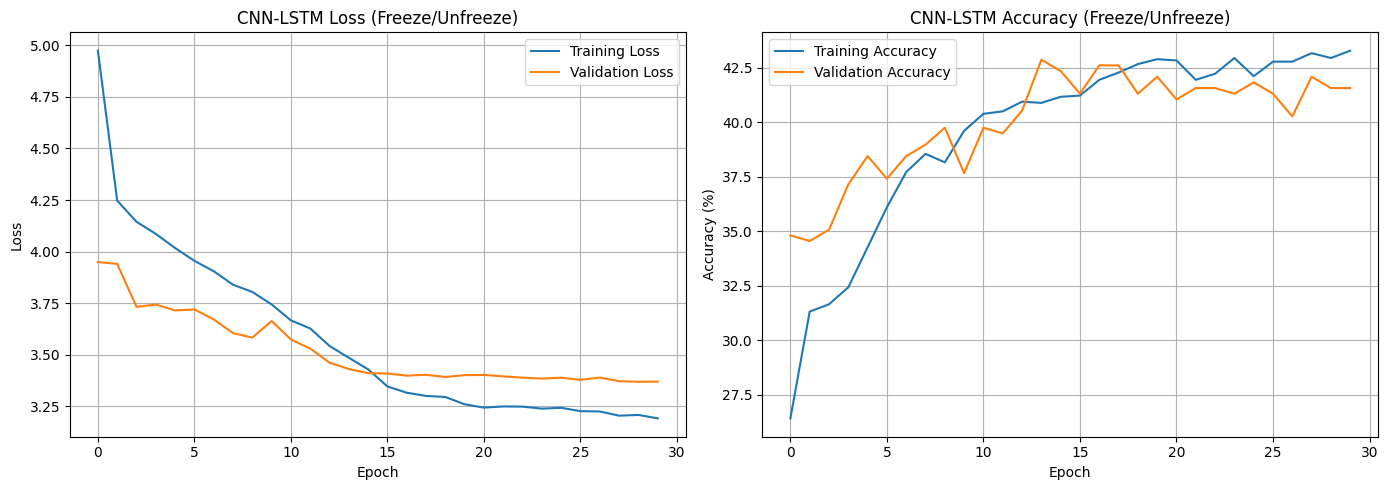

In [ ]:
#Training curves for CNN-LSTM(freeze/unfreeze)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cnn_lstm_freeze_history['train_loss'], label='Training Loss')
axes[0].plot(cnn_lstm_freeze_history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN-LSTM Loss (Freeze/Unfreeze)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(cnn_lstm_freeze_history['train_acc'], label='Training Accuracy')
axes[1].plot(cnn_lstm_freeze_history['val_acc'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('CNN-LSTM Accuracy (Freeze/Unfreeze)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plot_path = f'{MODEL_DIR}/cnn_lstm_freeze_unfreeze_training_curves.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

DETAILED EVALUATION: CNN-LSTM (Freeze/Unfreeze)
Loaded best model (Val Acc: 42.86%)
Running inference on test set...
Total samples: 450
Found 65 samples with missing answer (answer = -1)
These will be excluded from evaluation

Evaluating on 385 valid samples

OVERALL PERFORMANCE
Overall Accuracy: 42.86%
Overall F1-Score: 0.3217

PER-CLASS PERFORMANCE ANALYSIS

Top-10 Best Performing Classes:
Class                          Accuracy     Samples   
------------------------------------------------------------
no                              71.93%       114
yes                             71.55%       116
axial                            0.00%        12
fat                              0.00%         3
left                             0.00%         5
right                            0.00%         6
right sided pleural effusion     0.00%         3
mri                              0.00%         3
pa                               0.00%         5
enlarged                         0.00%         3

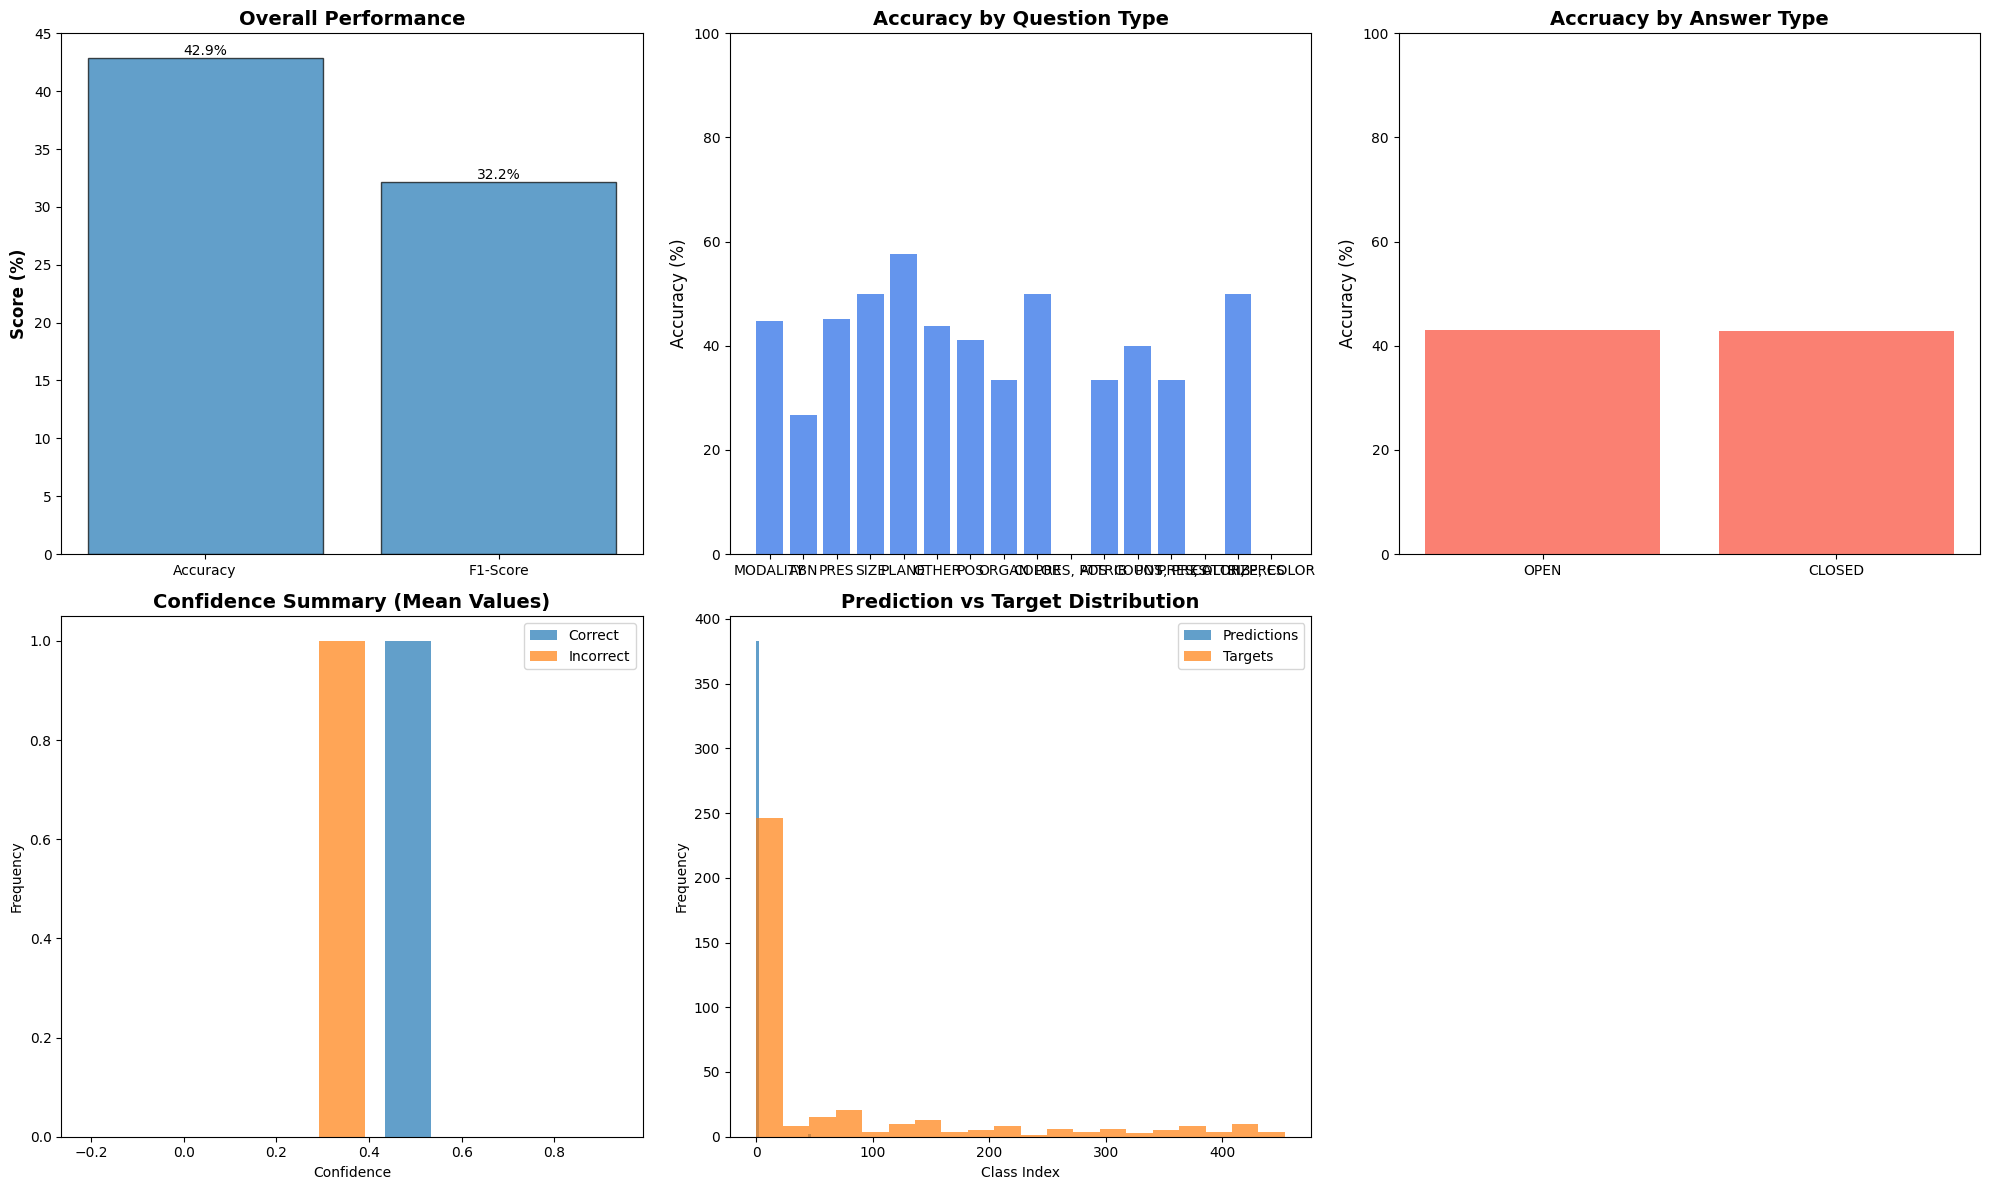

In [ ]:
print("="*60)
print("DETAILED EVALUATION: CNN-LSTM (Freeze/Unfreeze)")
print("="*60)

model = CNNLSTM(
    vocab_size=len(question_vocab),
    num_classes=len(answer_vocab),
    embedding_dim=512,
    hidden_dim=1024,
    dropout=0.5
).to(device)

checkpoint = torch.load(cnn_lstm_freeze_ckpt)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model (Val Acc: {checkpoint['best_val_acc']:.2f}%)")

results_cnn_lstm = detailed_evaluation(
    model,
    test_loader,
    answer_vocab,
    answer_idx_to_word,
    test_df,
    device,
    save_dir=f'{SAVE_DIR}/cnn_lstm_freeze_evaluation'
)

plot_detailed_results(
    results_cnn_lstm,
    save_dir=f'{SAVE_DIR}/cnn_lstm_freeze_evaluation'
)

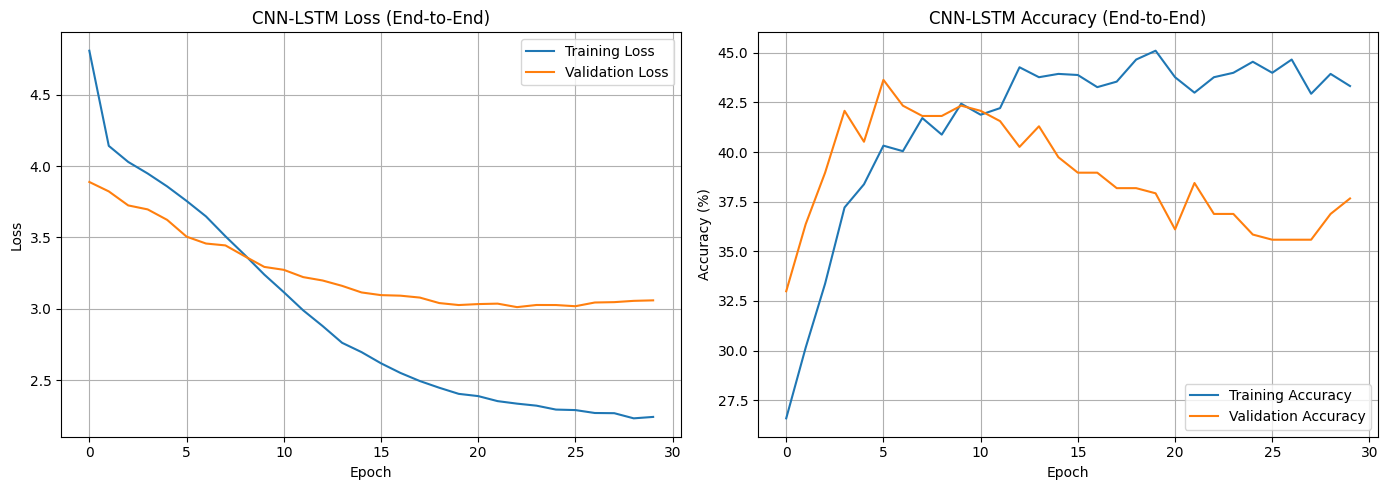

In [ ]:
#Training curves for CNN-LSTM(E2E)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cnn_lstm_e2e_history['train_loss'], label='Training Loss')
axes[0].plot(cnn_lstm_e2e_history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN-LSTM Loss (End-to-End)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(cnn_lstm_e2e_history['train_acc'], label='Training Accuracy')
axes[1].plot(cnn_lstm_e2e_history['val_acc'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('CNN-LSTM Accuracy (End-to-End)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plot_path = f'{MODEL_DIR}/cnn_lstm_e2e_training_curves.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

DETAILED EVALUATION: CNN-LSTM (End-to-End)
Loaded best model (Val Acc: 43.64%)
Running inference on test set...
Total samples: 450
Found 65 samples with missing answer (answer = -1)
These will be excluded from evaluation

Evaluating on 385 valid samples

OVERALL PERFORMANCE
Overall Accuracy: 43.64%
Overall F1-Score: 0.3283

PER-CLASS PERFORMANCE ANALYSIS
Skipping invalid label: 0
Skipping invalid label: 1
Skipping invalid label: 4
Skipping invalid label: 9
Skipping invalid label: 11
Skipping invalid label: 17
Skipping invalid label: 24
Skipping invalid label: 27
Skipping invalid label: 30
Skipping invalid label: 37
Skipping invalid label: 41
Skipping invalid label: 45
Skipping invalid label: 46
Skipping invalid label: 47
Skipping invalid label: 53
Skipping invalid label: 54
Skipping invalid label: 55
Skipping invalid label: 59
Skipping invalid label: 60
Skipping invalid label: 62
Skipping invalid label: 67
Skipping invalid label: 70
Skipping invalid label: 72
Skipping invalid label: 73

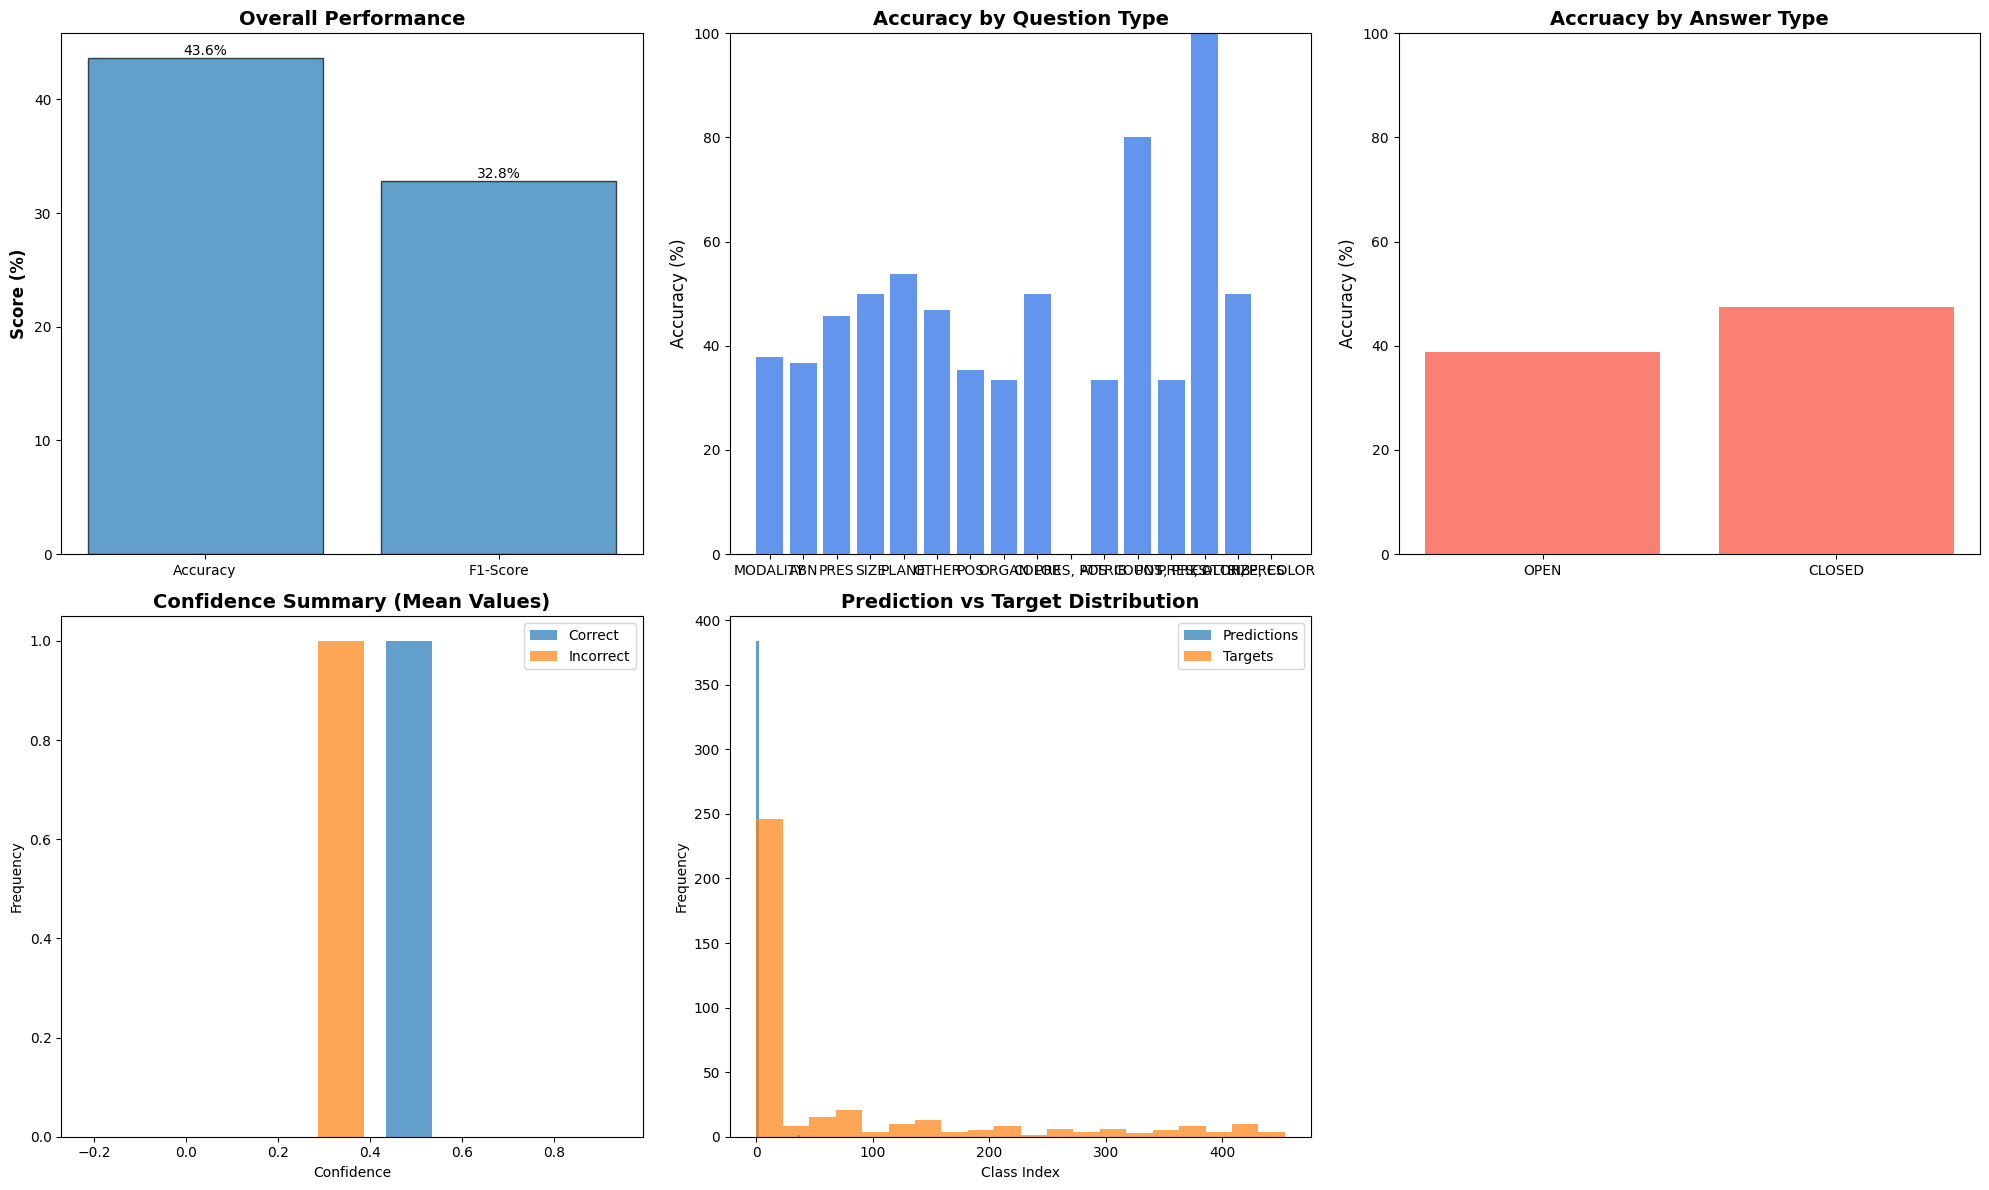

In [ ]:
print("="*60)
print("DETAILED EVALUATION: CNN-LSTM (End-to-End)")
print("="*60)

model = CNNLSTM(
    vocab_size=len(question_vocab),
    num_classes=len(answer_vocab),
    embedding_dim=512,
    hidden_dim=1024,
    dropout=0.5
).to(device)

checkpoint = torch.load(cnn_lstm_e2e_ckpt)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model (Val Acc: {checkpoint['best_val_acc']:.2f}%)")

results_cnn_lstm_e2e = detailed_evaluation(
    model,
    test_loader,
    answer_vocab,
    answer_idx_to_word,
    test_df,
    device,
    save_dir=f'{SAVE_DIR}/cnn_lstm_e2e_evaluation'
)

plot_detailed_results(
    results_cnn_lstm_e2e,
    save_dir=f'{SAVE_DIR}/cnn_lstm_e2e_evaluation'
)

# Proposed ViT + ClinicalBERT

In [ ]:
import torch.nn.functional as F
from transformers import ViTModel, ViTImageProcessor, AutoModel, AutoTokenizer
import time

In [ ]:
TRAIN_JSON = '/content/drive/MyDrive/VQA-RAD/woa7015outputs/train_data.json'
TEST_JSON = '/content/drive/MyDrive/VQA-RAD/woa7015outputs/test_data.json'
ANSWER_VOCAB = '/content/drive/MyDrive/VQA-RAD/woa7015outputs/answer_vocab.json'
ANSWER_IDX_TO_WORD = '/content/drive/MyDrive/VQA-RAD/woa7015outputs/answer_idx_to_word.json'

with open (TRAIN_JSON, 'r') as f:
  train_data = json.load(f)
with open (TEST_JSON, 'r') as f:
  test_data = json.load(f)

with open (ANSWER_VOCAB, 'r') as f:
  answer_vocab = json.load(f)
with open(ANSWER_IDX_TO_WORD, 'r') as f:
  answer_idx_to_word = json.load(f)

idx_to_word = {int(k): v for k, v in answer_idx_to_word.items()}
vocab_size = len(answer_vocab)

In [ ]:
#Load pre-trained models
vit_model_name = "google/vit-base-patch16-224"
clinicalbert_model_name = "emilyalsentzer/Bio_ClinicalBERT"

print(f"Loading ViT: {vit_model_name}")
vit_processor = ViTImageProcessor.from_pretrained(vit_model_name)
vit_model = ViTModel.from_pretrained(vit_model_name).to(device)
print(f"ViT model loaded: {sum(p.numel() for p in vit_model.parameters()):,} parameters")

print(f"Loading ClinicalBERT: {clinicalbert_model_name}")
clinicalbert_tokenizer = AutoTokenizer.from_pretrained(clinicalbert_model_name)
clinicalbert_model = AutoModel.from_pretrained(clinicalbert_model_name).to(device)
print(f"ClinicalBERT model loaded: {sum(p.numel() for p in clinicalbert_model.parameters()):,} parameters")

Loading ViT: google/vit-base-patch16-224


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT model loaded: 86,389,248 parameters
Loading ClinicalBERT: emilyalsentzer/Bio_ClinicalBERT


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

ClinicalBERT model loaded: 108,310,272 parameters


# ViT + ClinicalBERT Model Definition

In [ ]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, hidden_size=768, num_heads=8, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads

        # Question-to-Image Attention
        self.q2i_query = nn.Linear(hidden_size, hidden_size)
        self.q2i_key = nn.Linear(hidden_size, hidden_size)
        self.q2i_value = nn.Linear(hidden_size, hidden_size)
        self.q2i_out = nn.Linear(hidden_size, hidden_size)

        # Image-to-Question Attention
        self.i2q_query = nn.Linear(hidden_size, hidden_size)
        self.i2q_key = nn.Linear(hidden_size, hidden_size)
        self.i2q_value = nn.Linear(hidden_size, hidden_size)
        self.i2q_out = nn.Linear(hidden_size, hidden_size)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, image_features, question_features, attention_mask=None):
        batch_size = image_features.size(0)

        q_query = self.q2i_query(question_features)
        i_key = self.q2i_key(image_features)
        i_value = self.q2i_value(image_features)

        q_query = q_query.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        i_key = i_key.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        i_value = i_value.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        q2i_scores = torch.matmul(q_query, i_key.transpose(-2, -1)) / np.sqrt(self.head_dim)
        q2i_weights = torch.softmax(q2i_scores, dim=-1)
        q2i_output = torch.matmul(q2i_weights, i_value)
        q2i_output = q2i_output.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_size)
        q2i_output = self.q2i_out(q2i_output)
        q2i_output = self.layer_norm1(q2i_output + question_features)

        i_query = self.i2q_query(image_features)
        q_key = self.i2q_key(question_features)
        q_value = self.i2q_value(question_features)

        i_query = i_query.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        q_key = q_key.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        q_value = q_value.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        i2q_scores = torch.matmul(i_query, q_key.transpose(-2, -1)) / np.sqrt(self.head_dim)
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(1).unsqueeze(2)
            i2q_scores = i2q_scores.masked_fill(mask == 0, float('-inf'))

        i2q_weights = torch.softmax(i2q_scores, dim=-1)
        i2q_output = torch.matmul(i2q_weights, q_value)
        i2q_output = i2q_output.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_size)
        i2q_output = self.i2q_out(i2q_output)
        i2q_output = self.layer_norm2(i2q_output + image_features)

        fused_features = torch.cat([
            q2i_output[:, 0, :],
            i2q_output[:, 0, :]
        ], dim=1)

        return fused_features

print("CrossAttentionFusion module defined")

CrossAttentionFusion module defined


In [ ]:
class ViTClinicalBERTVQA(nn.Module):
    def __init__(self, vit_model, clinicalbert_model, clinicalbert_tokenizer,
                 vit_processor, num_answers=458, hidden_size=768, num_heads=8, dropout=0.1):
        super().__init__()

        self.vit = vit_model
        self.clinicalbert = clinicalbert_model
        self.tokenizer = clinicalbert_tokenizer
        self.processor = vit_processor

        self.fusion = CrossAttentionFusion(hidden_size, num_heads, dropout)

        # 3-layer classifier
        self.classifier = nn.Sequential(
            nn.Linear(1536, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_answers)
        )

        self._init_classifier_weights()

    def _init_classifier_weights(self):
        for module in self.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, pixel_values, input_ids, attention_mask):
        # Encode image and question
        image_features = self.vit(pixel_values=pixel_values).last_hidden_state
        question_features = self.clinicalbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # Fuse with cross-attention
        fused_features = self.fusion(image_features, question_features, attention_mask)

        # Classify
        logits = self.classifier(fused_features)
        return logits

    def freeze_encoders(self):
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.clinicalbert.parameters():
            param.requires_grad = False

    def unfreeze_top_layers_phase2(self):
        for i in range(9, 12):
            for param in self.vit.encoder.layer[i].parameters():
                param.requires_grad = True
        for i in range(8, 12):
            for param in self.clinicalbert.encoder.layer[i].parameters():
                param.requires_grad = True

    def unfreeze_all(self):
        for param in self.vit.parameters():
            param.requires_grad = True
        for param in self.clinicalbert.parameters():
            param.requires_grad = True

    def count_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total, trainable

# Transformer Dataset Definition

In [ ]:
class VQARADDatasetTransformer(Dataset):
    def __init__(self, data_path, image_dir, vit_processor, tokenizer, answer_vocab, max_question_length=50):
        with open(data_path, 'r') as f:
            self.data = json.load(f)

        self.image_dir = image_dir
        self.vit_processor = vit_processor
        self.tokenizer = tokenizer
        self.answer_vocab = answer_vocab
        self.max_question_length = max_question_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Load and process image
        image_path = os.path.join(self.image_dir, sample['image_name'])
        image = Image.open(image_path).convert('RGB')
        image_inputs = self.vit_processor(images=image, return_tensors="pt")
        pixel_values = image_inputs['pixel_values'].squeeze(0)

        # Tokenize question
        question_text = sample['question']
        question_inputs = self.tokenizer(
            question_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_question_length,
            return_tensors='pt'
        )

        input_ids = question_inputs['input_ids'].squeeze(0)
        attention_mask = question_inputs['attention_mask'].squeeze(0)

        # Get label
        answer_text = str(sample['answer']).lower().strip()
        label = self.answer_vocab.get(answer_text, -1)

        return {
            'pixel_values': pixel_values,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label,
            'question_text': question_text,
            'answer_text': answer_text,
            'question_type': sample.get('question_type', 'unknown'),
            'answer_type': sample.get('answer_type', 'UNKNOWN')
        }

print("Transfomer dataset class defined")

Transfomer dataset class defined


In [ ]:
train_dataset_vit = VQARADDatasetTransformer(
    TRAIN_JSON, IMAGE_DIR, vit_processor,
    clinicalbert_tokenizer, answer_vocab
)
test_dataset_vit = VQARADDatasetTransformer(
    TEST_JSON, IMAGE_DIR, vit_processor,
    clinicalbert_tokenizer, answer_vocab
)

BATCH_SIZE = 64
train_loader_vit = DataLoader(train_dataset_vit, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader_vit = DataLoader(test_dataset_vit, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# ViT + ClinicalBERT Training Function Definition

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, phase_name):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"{phase_name} Training")
    for batch in pbar:
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Filter out invalid labels (-1)
        valid_mask = (labels != -1)
        if valid_mask.sum() == 0:
            continue # Skip batch if no valid labels

        pixel_values = pixel_values[valid_mask]
        input_ids = input_ids[valid_mask]
        attention_mask = attention_mask[valid_mask]
        labels = labels[valid_mask]

        optimizer.zero_grad()
        logits = model(pixel_values, input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * labels.size(0) # Multiply by count of valid labels
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.0*correct/total:.2f}%'})

    if total == 0:
        return 0.0, 0.0
    return running_loss / total, 100.0 * correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Filter out invalid labels (-1)
            valid_mask = (labels != -1)
            if valid_mask.sum() == 0:
                continue # Skip batch if no valid labels

            pixel_values = pixel_values[valid_mask]
            input_ids = input_ids[valid_mask]
            attention_mask = attention_mask[valid_mask]
            labels = labels[valid_mask]

            logits = model(pixel_values, input_ids, attention_mask)
            loss = criterion(logits, labels)

            running_loss += loss.item() * labels.size(0) # Multiply by count of valid labels
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    if total == 0: # Handle case where all batches were skipped
        return 0.0, 0.0, 0.0

    acc = 100.0 * correct / total
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    return running_loss / total, acc, f1

print("Training functions defined")

Training functions defined


# ViT + ClinicalBERT Training

In [ ]:
def run_vit_clinicalbert(strategy, freeze_unfreeze=True, phase1_epochs=15, phase2_epochs=15, total_epochs=30):

  model = ViTClinicalBERTVQA(
    vit_model=vit_model,
    clinicalbert_model=clinicalbert_model,
    clinicalbert_tokenizer=clinicalbert_tokenizer,
    vit_processor=vit_processor,
    num_answers=vocab_size,
    hidden_size=768,
    num_heads=8,
    dropout=0.1
  ).to(device)

  if freeze_unfreeze:
    model.freeze_encoders()

  else:
    model.unfreeze_all()

  criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
  history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
  }
  best_val_acc = 0.0
  best_ckpt_path = f'{MODEL_DIR}/vit_clinicalbert_{strategy}_best.pt'

  if freeze_unfreeze:
    print("="*60)
    print(f"PHASE 1: {strategy} (Frozen Encoders)")
    print("="*60)

    optimizer_phase1 = optim.AdamW(
      filter(lambda p: p.requires_grad, model.parameters()),
      lr=3e-4,
      weight_decay=0.01
    )

    for epoch in range(1, phase1_epochs + 1):
      print(f"\nEpoch {epoch}/{total_epochs}")
      print("-" * 60)
      train_loss, train_acc = train_one_epoch(model, train_loader_vit, criterion, optimizer_phase1, device, "Phase 1")
      val_loss, val_acc, val_f1 = evaluate(model, test_loader_vit, criterion, device)

      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['val_f1'].append(val_f1)

      print(f"\nResults:")
      print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
      print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

      if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
          {
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer_phase1.state_dict(),
              'val_acc': val_acc,
              'best_val_acc': best_val_acc,
              'train_loss': train_loss,
              'train_acc': train_acc,
              'val_loss': val_loss,
          }, best_ckpt_path)
        print(f"  Best model saved! (Val Acc: {val_acc:.2f}%)")

    print("\n" + "="*60)
    print("PHASE 2: Fine-tuning Top Layers")
    print("="*60)

    model.unfreeze_top_layers_phase2()
    optimizer_phase2 = optim.AdamW([
      {'params': [p for p in model.vit.parameters() if p.requires_grad], 'lr': 5e-6},
      {'params': [p for p in model.clinicalbert.parameters() if p.requires_grad], 'lr': 2e-5},
      {'params': model.fusion.parameters(), 'lr': 1e-4},
      {'params': model.classifier.parameters(), 'lr': 1e-4}
    ], weight_decay=0.01)

    for epoch in range(1, phase2_epochs + 1):
      print(f"\nEpoch {phase1_epochs + epoch}/{total_epochs}")
      print("-" * 60)
      train_loss, train_acc = train_one_epoch(model, train_loader_vit, criterion, optimizer_phase2, device, "Phase 2")
      val_loss, val_acc, val_f1 = evaluate(model, test_loader_vit, criterion, device)

      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['val_f1'].append(val_f1)

      print(f"\nResults:")
      print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
      print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

      if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
          {
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer_phase2.state_dict(),
              'val_acc': val_acc,
              'best_val_acc': best_val_acc,
              'train_loss': train_loss,
              'train_acc': train_acc,
              'val_loss': val_loss
          }, best_ckpt_path)
        print(f"  Best model saved! (Val Acc: {val_acc:.2f}%)")
    print(f"\n{strategy} Complete! Best Val Acc: {best_val_acc:.2f}%")

  else:
    print("\n" + "="*60)
    print("End-to-End Training")
    print("="*60)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    for epoch in range(1, total_epochs + 1):
      print(f"\nEpoch {epoch}/{total_epochs}")
      print("-" * 60)
      train_loss, train_acc = train_one_epoch(model, train_loader_vit, criterion, optimizer, device, "End-to-End")
      val_loss, val_acc, val_f1 = evaluate(model, test_loader_vit, criterion, device)

      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['val_f1'].append(val_f1)

      print(f"\nResults:")
      print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
      print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")

      if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
          {
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'val_acc': val_acc,
              'best_val_acc': best_val_acc,
              'train_loss': train_loss,
              'train_acc': train_acc,
              'val_loss': val_loss
          },best_ckpt_path)
        print(f"  Best model saved! (Val Acc: {val_acc:.2f}%)")
    print(f"\n{strategy} Complete! Best Val Acc: {best_val_acc:.2f}%")

  return model, history, best_ckpt_path

In [ ]:
vit_freeze_model, vit_freeze_history, vit_freeze_best_ckpt_path = run_vit_clinicalbert(
    strategy='freeze_unfreeze',
    freeze_unfreeze=True,
    phase1_epochs=15,
    phase2_epochs=15,
)

vit_e2e_model, vit_e2e_history, vit_e2e_best_ckpt_path = run_vit_clinicalbert(
    strategy='end_to_end',
    freeze_unfreeze=False,
    total_epochs=30
)

PHASE 1: freeze_unfreeze (Frozen Encoders)

Epoch 1/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]



Results:
  Train Loss: 4.2694 | Train Acc: 29.53%
  Val Loss: 3.4391 | Val Acc: 32.21% | Val F1: 0.1937
  Best model saved! (Val Acc: 32.21%)

Epoch 2/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]



Results:
  Train Loss: 3.6096 | Train Acc: 36.60%
  Val Loss: 3.1522 | Val Acc: 43.38% | Val F1: 0.3611
  Best model saved! (Val Acc: 43.38%)

Epoch 3/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]



Results:
  Train Loss: 3.3065 | Train Acc: 39.15%
  Val Loss: 2.9414 | Val Acc: 44.68% | Val F1: 0.3921
  Best model saved! (Val Acc: 44.68%)

Epoch 4/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]



Results:
  Train Loss: 3.0430 | Train Acc: 43.99%
  Val Loss: 2.7942 | Val Acc: 46.75% | Val F1: 0.4199
  Best model saved! (Val Acc: 46.75%)

Epoch 5/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]



Results:
  Train Loss: 2.7277 | Train Acc: 49.94%
  Val Loss: 2.6840 | Val Acc: 47.27% | Val F1: 0.4348
  Best model saved! (Val Acc: 47.27%)

Epoch 6/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.20it/s]



Results:
  Train Loss: 2.4070 | Train Acc: 55.17%
  Val Loss: 2.5073 | Val Acc: 52.99% | Val F1: 0.4997
  Best model saved! (Val Acc: 52.99%)

Epoch 7/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]



Results:
  Train Loss: 2.1190 | Train Acc: 64.57%
  Val Loss: 2.4136 | Val Acc: 54.03% | Val F1: 0.4999
  Best model saved! (Val Acc: 54.03%)

Epoch 8/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.21it/s]



Results:
  Train Loss: 1.9190 | Train Acc: 68.19%
  Val Loss: 2.2892 | Val Acc: 59.22% | Val F1: 0.5720
  Best model saved! (Val Acc: 59.22%)

Epoch 9/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.20it/s]



Results:
  Train Loss: 1.7671 | Train Acc: 73.92%
  Val Loss: 2.3399 | Val Acc: 56.36% | Val F1: 0.5354

Epoch 10/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]



Results:
  Train Loss: 1.6364 | Train Acc: 77.86%
  Val Loss: 2.1989 | Val Acc: 60.52% | Val F1: 0.5919
  Best model saved! (Val Acc: 60.52%)

Epoch 11/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]



Results:
  Train Loss: 1.5110 | Train Acc: 82.48%
  Val Loss: 2.1842 | Val Acc: 60.52% | Val F1: 0.6041

Epoch 12/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]



Results:
  Train Loss: 1.4265 | Train Acc: 85.37%
  Val Loss: 2.2434 | Val Acc: 62.08% | Val F1: 0.6073
  Best model saved! (Val Acc: 62.08%)

Epoch 13/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]



Results:
  Train Loss: 1.3726 | Train Acc: 87.88%
  Val Loss: 2.1291 | Val Acc: 65.45% | Val F1: 0.6530
  Best model saved! (Val Acc: 65.45%)

Epoch 14/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]



Results:
  Train Loss: 1.3259 | Train Acc: 90.27%
  Val Loss: 2.1766 | Val Acc: 65.45% | Val F1: 0.6552

Epoch 15/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]



Results:
  Train Loss: 1.2851 | Train Acc: 91.77%
  Val Loss: 2.1634 | Val Acc: 65.45% | Val F1: 0.6535

PHASE 2: Fine-tuning Top Layers

Epoch 16/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]



Results:
  Train Loss: 1.2009 | Train Acc: 94.44%
  Val Loss: 2.1238 | Val Acc: 67.01% | Val F1: 0.6711
  Best model saved! (Val Acc: 67.01%)

Epoch 17/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]



Results:
  Train Loss: 1.1363 | Train Acc: 97.05%
  Val Loss: 2.1104 | Val Acc: 68.83% | Val F1: 0.6921
  Best model saved! (Val Acc: 68.83%)

Epoch 18/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]



Results:
  Train Loss: 1.1117 | Train Acc: 97.78%
  Val Loss: 2.1439 | Val Acc: 66.75% | Val F1: 0.6710

Epoch 19/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]



Results:
  Train Loss: 1.1051 | Train Acc: 97.83%
  Val Loss: 2.1322 | Val Acc: 68.83% | Val F1: 0.6849

Epoch 20/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]



Results:
  Train Loss: 1.0988 | Train Acc: 97.66%
  Val Loss: 2.1210 | Val Acc: 69.09% | Val F1: 0.6905
  Best model saved! (Val Acc: 69.09%)

Epoch 21/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]



Results:
  Train Loss: 1.0852 | Train Acc: 98.61%
  Val Loss: 2.1139 | Val Acc: 70.13% | Val F1: 0.7010
  Best model saved! (Val Acc: 70.13%)

Epoch 22/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]



Results:
  Train Loss: 1.0667 | Train Acc: 99.17%
  Val Loss: 2.1468 | Val Acc: 69.61% | Val F1: 0.6915

Epoch 23/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]



Results:
  Train Loss: 1.0693 | Train Acc: 98.78%
  Val Loss: 2.1280 | Val Acc: 69.35% | Val F1: 0.6973

Epoch 24/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]



Results:
  Train Loss: 1.0595 | Train Acc: 99.11%
  Val Loss: 2.1268 | Val Acc: 69.35% | Val F1: 0.6944

Epoch 25/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]



Results:
  Train Loss: 1.0543 | Train Acc: 99.22%
  Val Loss: 2.1201 | Val Acc: 69.61% | Val F1: 0.6945

Epoch 26/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]



Results:
  Train Loss: 1.0552 | Train Acc: 98.67%
  Val Loss: 2.1747 | Val Acc: 68.57% | Val F1: 0.6865

Epoch 27/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]



Results:
  Train Loss: 1.0412 | Train Acc: 99.22%
  Val Loss: 2.1444 | Val Acc: 69.35% | Val F1: 0.6863

Epoch 28/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]



Results:
  Train Loss: 1.0410 | Train Acc: 99.50%
  Val Loss: 2.1136 | Val Acc: 71.17% | Val F1: 0.7104
  Best model saved! (Val Acc: 71.17%)

Epoch 29/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]



Results:
  Train Loss: 1.0389 | Train Acc: 99.33%
  Val Loss: 2.1137 | Val Acc: 69.35% | Val F1: 0.6958

Epoch 30/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]



Results:
  Train Loss: 1.0319 | Train Acc: 99.50%
  Val Loss: 2.1450 | Val Acc: 69.87% | Val F1: 0.6976

freeze_unfreeze Complete! Best Val Acc: 71.17%

End-to-End Training

Epoch 1/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]



Results:
  Train Loss: 4.0611 | Train Acc: 31.26%
  Val Loss: 3.2962 | Val Acc: 40.78% | Val F1: 0.3508
  Best model saved! (Val Acc: 40.78%)

Epoch 2/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]



Results:
  Train Loss: 3.5635 | Train Acc: 38.77%
  Val Loss: 3.1396 | Val Acc: 43.12% | Val F1: 0.3908
  Best model saved! (Val Acc: 43.12%)

Epoch 3/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]



Results:
  Train Loss: 3.2210 | Train Acc: 48.83%
  Val Loss: 2.9193 | Val Acc: 50.39% | Val F1: 0.4782
  Best model saved! (Val Acc: 50.39%)

Epoch 4/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]



Results:
  Train Loss: 2.8406 | Train Acc: 56.84%
  Val Loss: 2.6905 | Val Acc: 54.29% | Val F1: 0.4981
  Best model saved! (Val Acc: 54.29%)

Epoch 5/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]



Results:
  Train Loss: 2.3775 | Train Acc: 67.52%
  Val Loss: 2.5076 | Val Acc: 59.22% | Val F1: 0.5599
  Best model saved! (Val Acc: 59.22%)

Epoch 6/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]



Results:
  Train Loss: 1.8977 | Train Acc: 78.20%
  Val Loss: 2.3163 | Val Acc: 65.19% | Val F1: 0.6313
  Best model saved! (Val Acc: 65.19%)

Epoch 7/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.21it/s]



Results:
  Train Loss: 1.5179 | Train Acc: 87.93%
  Val Loss: 2.3488 | Val Acc: 64.94% | Val F1: 0.6255

Epoch 8/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]



Results:
  Train Loss: 1.2970 | Train Acc: 93.27%
  Val Loss: 2.1424 | Val Acc: 68.05% | Val F1: 0.6750
  Best model saved! (Val Acc: 68.05%)

Epoch 9/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]



Results:
  Train Loss: 1.2005 | Train Acc: 95.83%
  Val Loss: 2.0904 | Val Acc: 70.65% | Val F1: 0.7030
  Best model saved! (Val Acc: 70.65%)

Epoch 10/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]



Results:
  Train Loss: 1.1357 | Train Acc: 97.44%
  Val Loss: 2.2261 | Val Acc: 69.35% | Val F1: 0.6968

Epoch 11/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.19it/s]



Results:
  Train Loss: 1.1079 | Train Acc: 98.11%
  Val Loss: 2.1775 | Val Acc: 70.91% | Val F1: 0.7056
  Best model saved! (Val Acc: 70.91%)

Epoch 12/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]



Results:
  Train Loss: 1.0998 | Train Acc: 97.94%
  Val Loss: 2.1555 | Val Acc: 69.87% | Val F1: 0.6982

Epoch 13/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]



Results:
  Train Loss: 1.0842 | Train Acc: 98.50%
  Val Loss: 2.3466 | Val Acc: 69.61% | Val F1: 0.6955

Epoch 14/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]



Results:
  Train Loss: 1.0712 | Train Acc: 98.89%
  Val Loss: 2.1245 | Val Acc: 65.71% | Val F1: 0.6557

Epoch 15/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]



Results:
  Train Loss: 1.0658 | Train Acc: 99.39%
  Val Loss: 2.1261 | Val Acc: 70.13% | Val F1: 0.7009

Epoch 16/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.19it/s]



Results:
  Train Loss: 1.0607 | Train Acc: 99.33%
  Val Loss: 2.1514 | Val Acc: 70.91% | Val F1: 0.7060

Epoch 17/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]



Results:
  Train Loss: 1.0629 | Train Acc: 98.78%
  Val Loss: 2.2946 | Val Acc: 70.13% | Val F1: 0.6946

Epoch 18/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]



Results:
  Train Loss: 1.0483 | Train Acc: 99.44%
  Val Loss: 2.3278 | Val Acc: 70.65% | Val F1: 0.6991

Epoch 19/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]



Results:
  Train Loss: 1.0371 | Train Acc: 99.78%
  Val Loss: 2.2679 | Val Acc: 70.39% | Val F1: 0.7061

Epoch 20/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.19it/s]



Results:
  Train Loss: 1.0346 | Train Acc: 99.78%
  Val Loss: 2.3625 | Val Acc: 70.91% | Val F1: 0.7020

Epoch 21/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]



Results:
  Train Loss: 1.0308 | Train Acc: 99.83%
  Val Loss: 2.2619 | Val Acc: 69.87% | Val F1: 0.6943

Epoch 22/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]



Results:
  Train Loss: 1.0271 | Train Acc: 99.78%
  Val Loss: 2.2750 | Val Acc: 71.69% | Val F1: 0.7148
  Best model saved! (Val Acc: 71.69%)

Epoch 23/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]



Results:
  Train Loss: 1.0294 | Train Acc: 99.72%
  Val Loss: 2.2280 | Val Acc: 71.95% | Val F1: 0.7198
  Best model saved! (Val Acc: 71.95%)

Epoch 24/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]



Results:
  Train Loss: 1.0232 | Train Acc: 99.78%
  Val Loss: 2.2253 | Val Acc: 75.06% | Val F1: 0.7522
  Best model saved! (Val Acc: 75.06%)

Epoch 25/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]



Results:
  Train Loss: 1.0204 | Train Acc: 99.89%
  Val Loss: 2.2668 | Val Acc: 72.47% | Val F1: 0.7205

Epoch 26/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]



Results:
  Train Loss: 1.0178 | Train Acc: 99.89%
  Val Loss: 2.3764 | Val Acc: 69.87% | Val F1: 0.6997

Epoch 27/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]



Results:
  Train Loss: 1.0127 | Train Acc: 99.83%
  Val Loss: 2.4623 | Val Acc: 69.87% | Val F1: 0.6972

Epoch 28/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]



Results:
  Train Loss: 1.0153 | Train Acc: 99.94%
  Val Loss: 2.4305 | Val Acc: 70.13% | Val F1: 0.6972

Epoch 29/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]



Results:
  Train Loss: 1.0171 | Train Acc: 99.78%
  Val Loss: 2.3549 | Val Acc: 69.61% | Val F1: 0.6898

Epoch 30/30
------------------------------------------------------------


Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


Results:
  Train Loss: 1.0073 | Train Acc: 99.89%
  Val Loss: 2.2881 | Val Acc: 71.69% | Val F1: 0.7129

end_to_end Complete! Best Val Acc: 75.06%


#ViT + ClinicalBERT Results

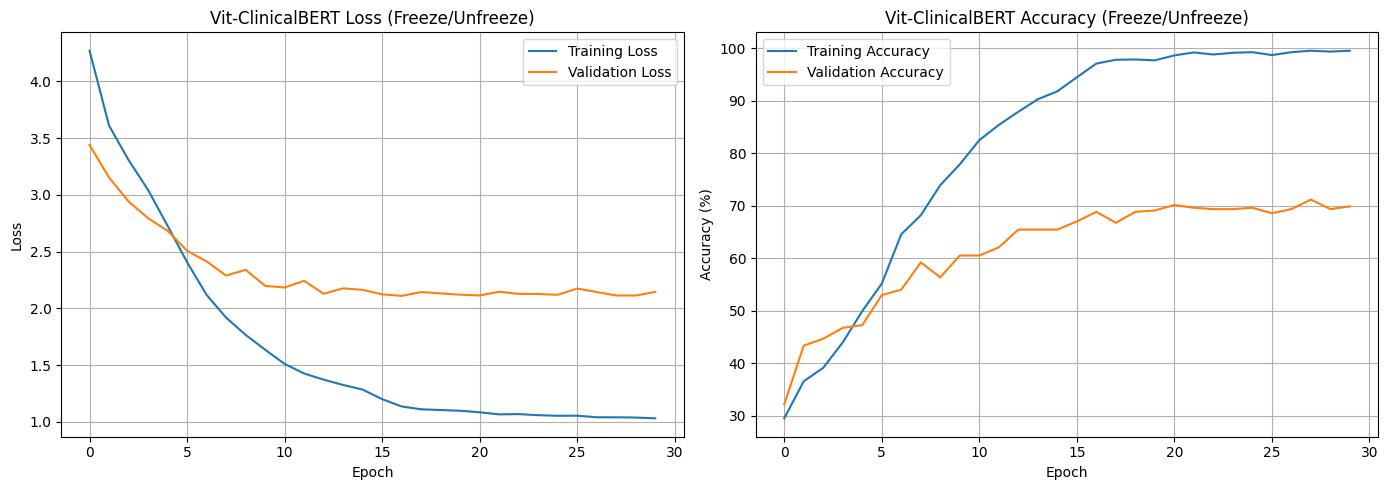

In [ ]:
# Training curves for Vit-ClinicalBERT (freeze/unfreeze)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(vit_freeze_history['train_loss'], label='Training Loss')
axes[0].plot(vit_freeze_history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Vit-ClinicalBERT Loss (Freeze/Unfreeze)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(vit_freeze_history['train_acc'], label='Training Accuracy')
axes[1].plot(vit_freeze_history['val_acc'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Vit-ClinicalBERT Accuracy (Freeze/Unfreeze)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plot_path = f'{MODEL_DIR}/vit-clinicalbert_freeze_training_curves.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

DETAILED EVALUATION: ViT + ClinicalBERT (Freeze/Unfreeze)
Loaded best model (Val Acc: 71.17%)
Running inference on test set...
Total samples: 450
Found 65 samples with missing answer (answer = -1)
These will be excluded from evaluation

Evaluating on 385 valid samples

OVERALL PERFORMANCE
Overall Accuracy: 71.17%
Overall F1-Score: 0.7104

PER-CLASS PERFORMANCE ANALYSIS

Top-10 Best Performing Classes:
Class                          Accuracy     Samples   
------------------------------------------------------------
right sided pleural effusion   100.00%         3
right                           83.33%         6
axial                           83.33%        12
no                              78.95%       114
yes                             71.55%       116
mri                             66.67%         3
fat                             66.67%         3
pa                              60.00%         5
left                            40.00%         5
enlarged                        33.33%

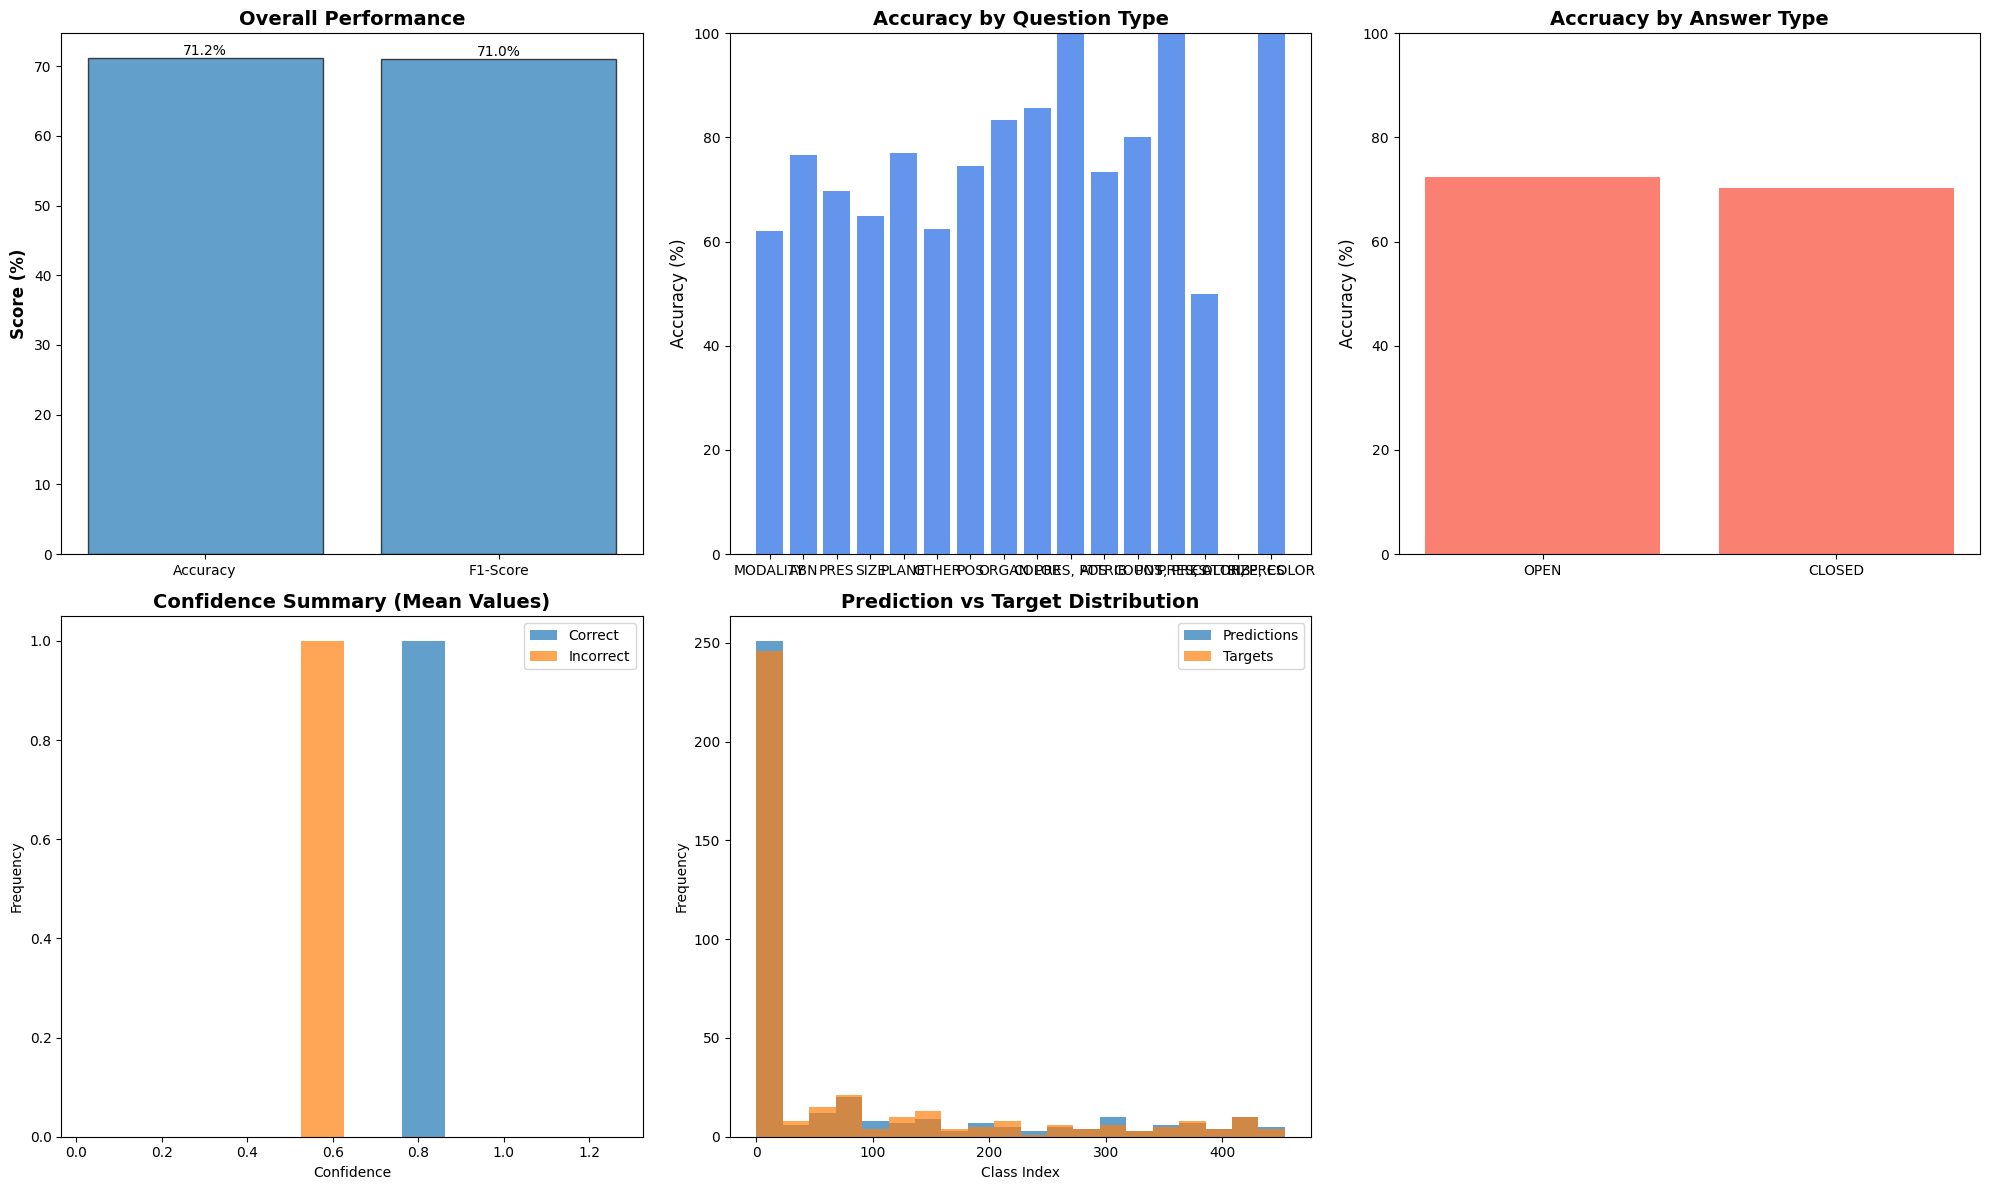

In [ ]:
print("="*60)
print("DETAILED EVALUATION: ViT + ClinicalBERT (Freeze/Unfreeze)")
print("="*60)

model = ViTClinicalBERTVQA(
    vit_model=vit_model,
    clinicalbert_model=clinicalbert_model,
    clinicalbert_tokenizer=clinicalbert_tokenizer,
    vit_processor=vit_processor,
    num_answers=vocab_size,
    hidden_size=768,
    num_heads=8,
    dropout=0.1
).to(device)

checkpoint = torch.load(vit_freeze_best_ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model (Val Acc: {checkpoint['val_acc']:.2f}%)")

results_vit_freeze = detailed_evaluation(
    model,
    test_loader_vit,
    answer_vocab,
    idx_to_word,
    test_df,
    device,
    save_dir=f'{SAVE_DIR}/vit_clinicalbert_freeze'
)
plot_detailed_results(results_vit_freeze, save_dir=f'{SAVE_DIR}/vit_clinicalbert_freeze')

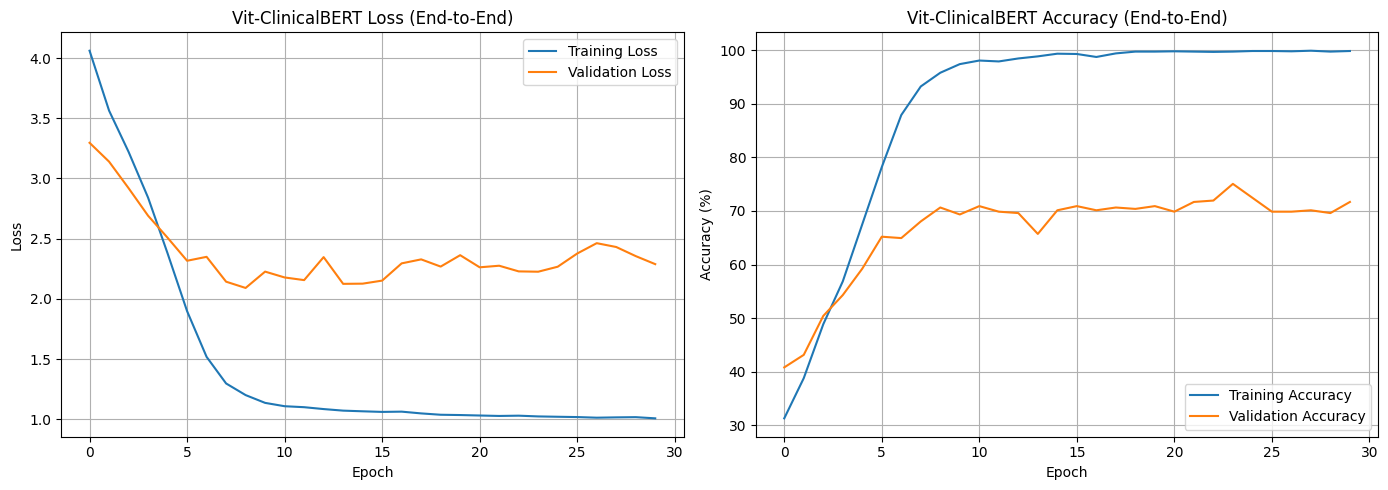

In [ ]:
# Training curves for Vit-ClinicalBERT (E2E)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(vit_e2e_history['train_loss'], label='Training Loss')
axes[0].plot(vit_e2e_history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Vit-ClinicalBERT Loss (End-to-End)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(vit_e2e_history['train_acc'], label='Training Accuracy')
axes[1].plot(vit_e2e_history['val_acc'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Vit-ClinicalBERT Accuracy (End-to-End)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plot_path = f'{MODEL_DIR}/vit-clinicalbert_e2e_training_curves.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

DETAILED EVALUATION: ViT + ClinicalBERT (End-to-End)
Loaded best model (Val Acc: 75.06%)
Running inference on test set...
Total samples: 450
Found 65 samples with missing answer (answer = -1)
These will be excluded from evaluation

Evaluating on 385 valid samples

OVERALL PERFORMANCE
Overall Accuracy: 75.06%
Overall F1-Score: 0.7522

PER-CLASS PERFORMANCE ANALYSIS

Top-10 Best Performing Classes:
Class                          Accuracy     Samples   
------------------------------------------------------------
right sided pleural effusion   100.00%         3
mri                            100.00%         3
pa                             100.00%         5
axial                           91.67%        12
right                           83.33%         6
yes                             75.86%       116
no                              75.44%       114
fat                             66.67%         3
left                            60.00%         5
enlarged                        33.33%     

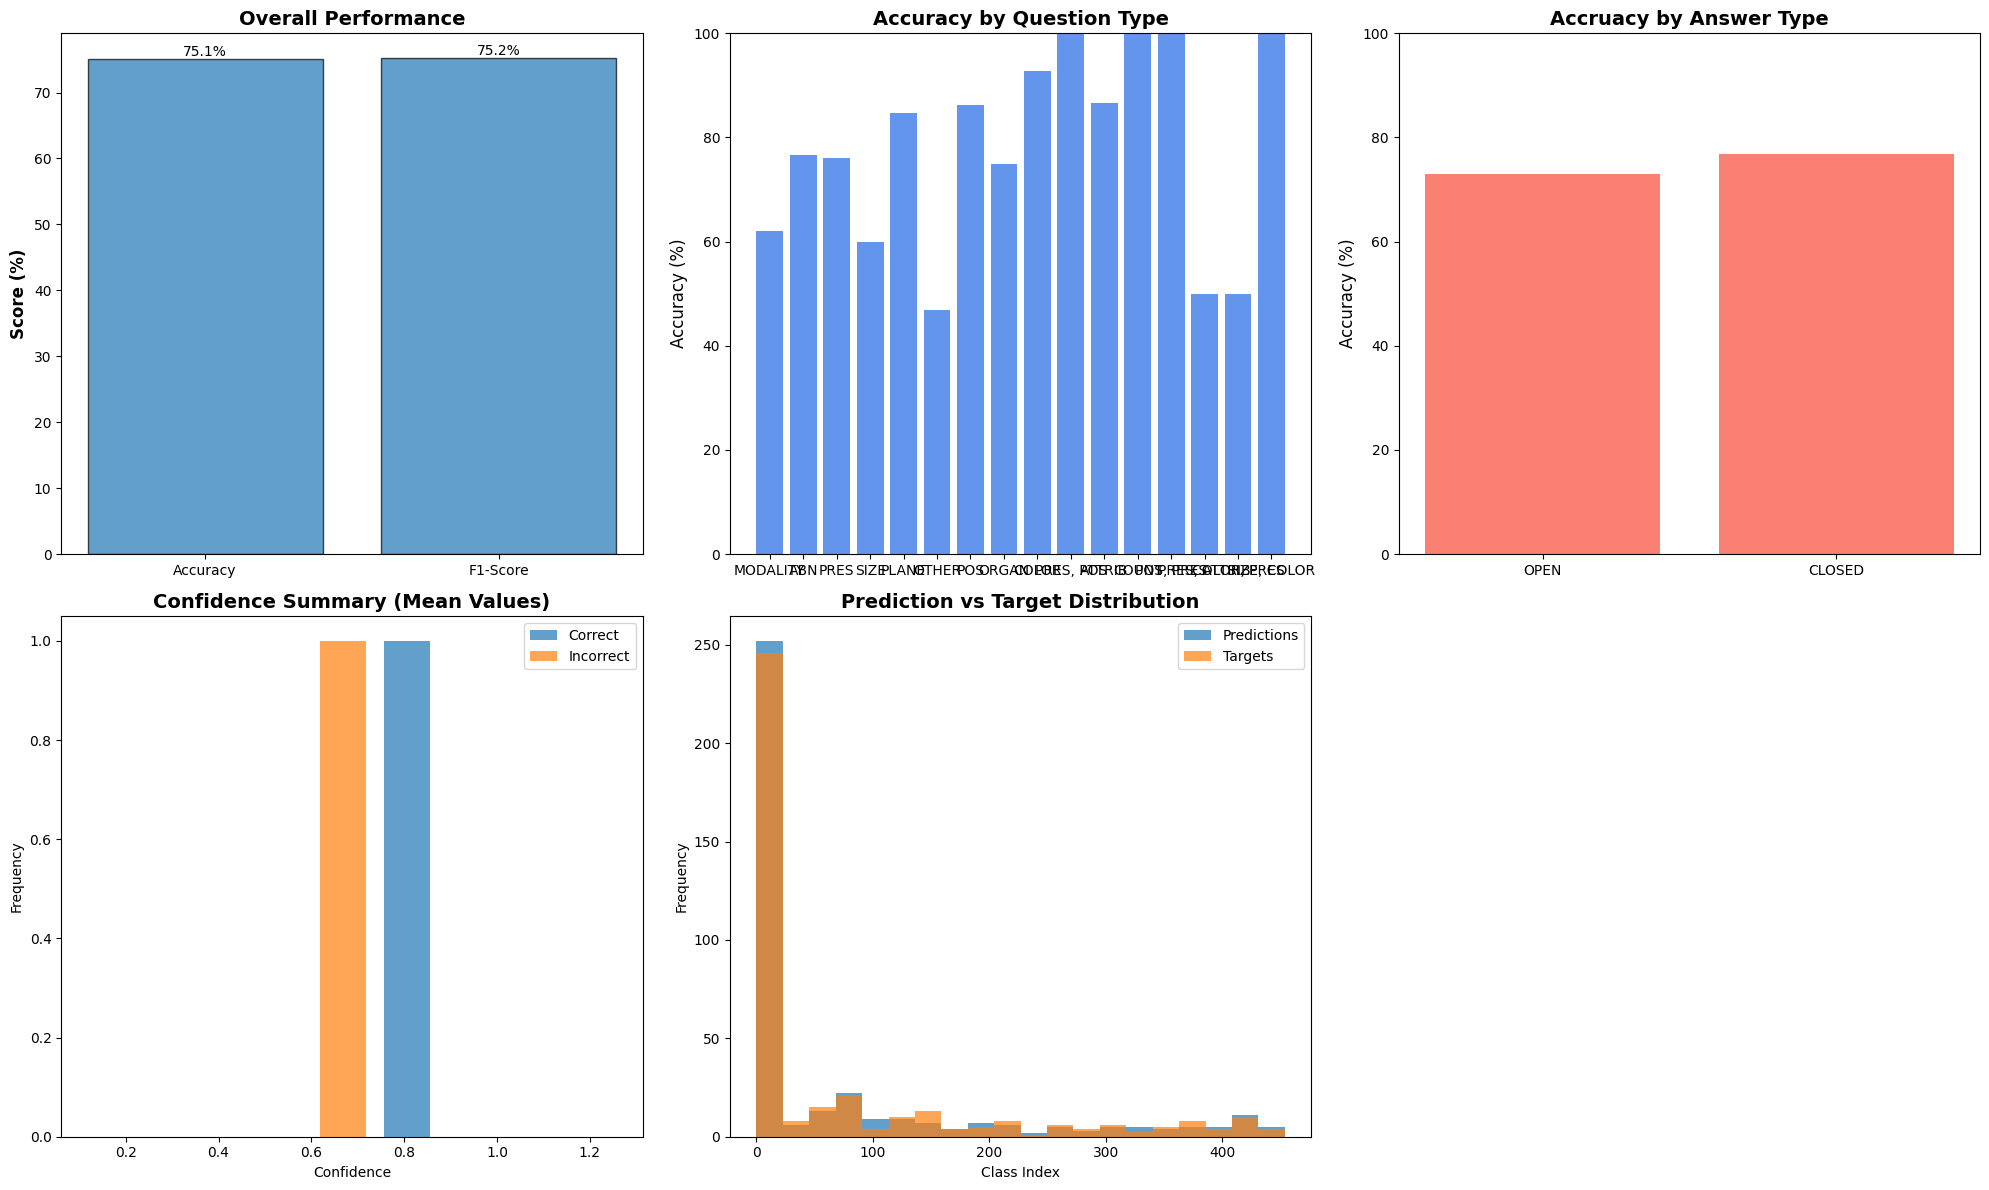

In [ ]:
print("="*60)
print("DETAILED EVALUATION: ViT + ClinicalBERT (End-to-End)")
print("="*60)

model = ViTClinicalBERTVQA(
    vit_model=vit_model,
    clinicalbert_model=clinicalbert_model,
    clinicalbert_tokenizer=clinicalbert_tokenizer,
    vit_processor=vit_processor,
    num_answers=vocab_size,
    hidden_size=768,
    num_heads=8,
    dropout=0.1
).to(device)

checkpoint = torch.load(vit_e2e_best_ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model (Val Acc: {checkpoint['val_acc']:.2f}%)")

results_vit_e2e = detailed_evaluation(
    model,
    test_loader_vit,
    answer_vocab,
    idx_to_word,
    test_df,
    device,
    save_dir=f'{SAVE_DIR}/vit_clinicalbert_e2e'
)
plot_detailed_results(results_vit_e2e, save_dir=f'{SAVE_DIR}/vit_clinicalbert_e2e')

# Overall Analysis

In [ ]:
# Aggregate metrics for comparison
summary_metrics = pd.DataFrame([
    {
        'Model': 'CNN-LSTM (Freeze/Unfreeze)',
        'Accuracy': results_cnn_lstm['overall']['accuracy'] * 100,
        'F1': results_cnn_lstm['overall']['f1_score'] * 100
    },
    {
        'Model': 'CNN-LSTM (End-to-End)',
        'Accuracy': results_cnn_lstm_e2e['overall']['accuracy'] * 100,
        'F1': results_cnn_lstm_e2e['overall']['f1_score'] * 100
    },
    {
        'Model': 'ViT+ClinicalBERT (Freeze/Unfreeze)',
        'Accuracy': results_vit_freeze['overall']['accuracy'] * 100,
        'F1': results_vit_freeze['overall']['f1_score'] * 100
    },
    {
        'Model': 'ViT+ClinicalBERT (End-to-End)',
        'Accuracy': results_vit_e2e['overall']['accuracy'] * 100,
        'F1': results_vit_e2e['overall']['f1_score'] * 100
    }
])

summary_metrics
summary_metrics_path = f'{SAVE_DIR}/summary_metrics.csv'
summary_metrics.to_csv(summary_metrics_path, index=False)
print(f"Saved summary metrics to {summary_metrics_path}")

Saved summary metrics to /content/drive/MyDrive/VQA-RAD/woa7015outputs/summary_metrics.csv


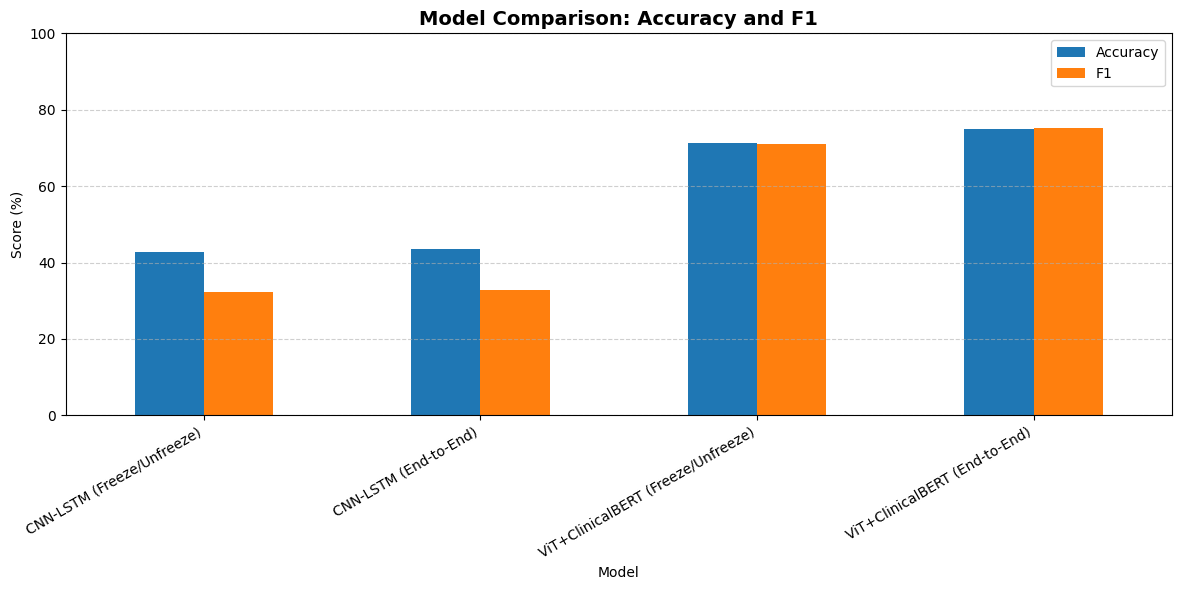

In [ ]:
# Bar plot: Accuracy and F1 comparison
fig, ax = plt.subplots(figsize=(12, 6))
summary_metrics.set_index('Model')[['Accuracy', 'F1']].plot(kind='bar', ax=ax)
ax.set_title('Model Comparison: Accuracy and F1', fontsize=14, fontweight='bold')
ax.set_ylabel('Score (%)')
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plot_path = f'{MODEL_DIR}/model_comparison.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

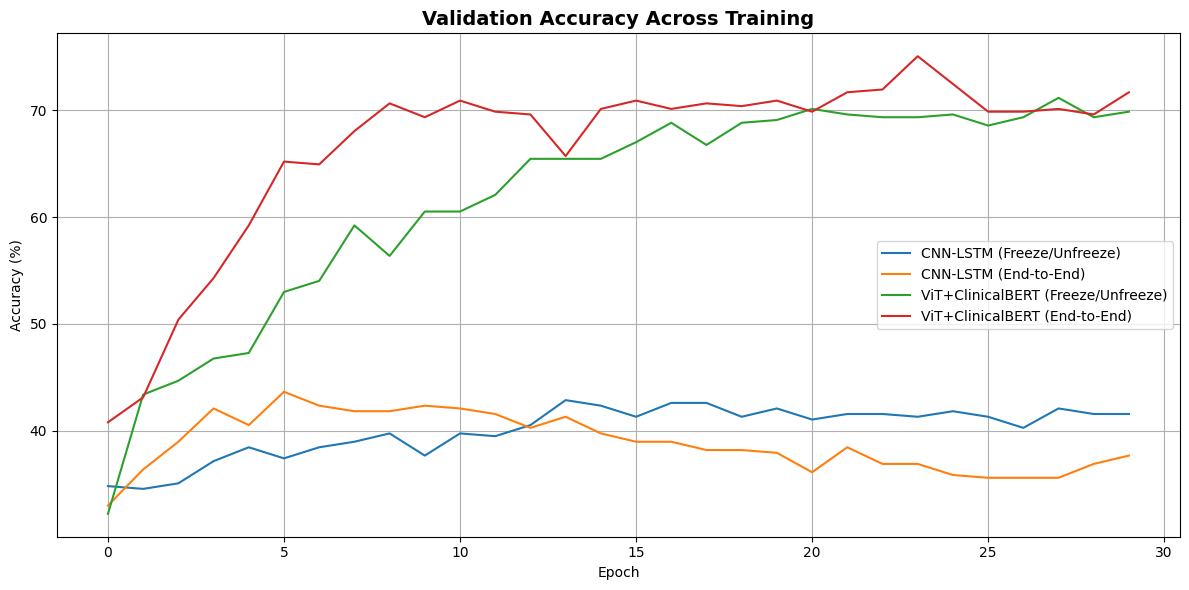

In [ ]:
# Line plot: Validation accuracy over epochs
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cnn_lstm_freeze_history['val_acc'], label='CNN-LSTM (Freeze/Unfreeze)')
ax.plot(cnn_lstm_e2e_history['val_acc'], label='CNN-LSTM (End-to-End)')
ax.plot(vit_freeze_history['val_acc'], label='ViT+ClinicalBERT (Freeze/Unfreeze)')
ax.plot(vit_e2e_history['val_acc'], label='ViT+ClinicalBERT (End-to-End)')
ax.set_title('Validation Accuracy Across Training', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.grid(True)
ax.legend()
plt.tight_layout()
plot_path = f'{MODEL_DIR}/validation_accuracy_across_training_all_models.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()